In [1]:
import re
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xfeat
from xfeat.cat_encoder import TargetEncoder
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import optuna.integration.lightgbm as lgb

In [2]:
all_new = pd.read_csv('data/feature_df_agg_svd16.csv')

In [3]:
def run_optuna_lgbm(test, train, target_cols, feature_cols, categorical_cols, seed):
    """
    import optuna.integration.lightgbm as lgb
    """
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    importances = []
    
    #cv = KFold(n_splits=5, shuffle=True, random_state=0)
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, X_train["category2"])):
        X_tr = X_train.iloc[train_index]
        X_val = X_train.iloc[valid_index]
        y_tr = y_train.iloc[train_index]
        y_val = y_train.iloc[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=False,
                          num_boost_round=1000,
                          early_stopping_rounds=10,
                          )
        
        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
        
        # display importance
        importance = pd.DataFrame(model.feature_importance(), index=X_test.columns, columns=['importance'])
        display(importance)
        importances.append(importance)

    return oof_train, sum(y_preds) / len(y_preds), importances

In [4]:
FEATURE_COLS = list(all_new.columns.drop(["id", "state","data_type"]))
print(len(FEATURE_COLS))
CATEGORICAL_COLS = [
    "country",
    "category1",
    "category2",
    "country+category1",
    "country+category2",
    "category1+category2",
]

859


In [5]:
TARGET_COLS = ["state"]
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
    }

In [6]:
test_set = all_new[all_new["data_type"] == "test"]
train_set = all_new[all_new["data_type"] == "train"]

In [7]:
def recursive_feature_selection(test_set, train_set, target_cols, feature_cols, categorical_cols, seed):
    worst_exist = True
    while worst_exist == True:
        oof, preds, importances = run_optuna_lgbm(test_set, train_set, target_cols, feature_cols, categorical_cols, seed)
        #oof, preds, importances = run_lgbm_with_te(test_set, train_set, target_cols, feature_cols, categorical_cols)
        worst_features = check_worst_features(importances, 5)
        if worst_features == set():
            worst_exist = False
        else:
            for feature in worst_features:
                feature_cols.remove(feature)
                for category in categorical_cols:
                    if category not in feature_cols:
                        print(category)
                        categorical_cols.remove(category)
    return oof, preds, importances, feature_cols

In [8]:
def check_worst_features(importances, imp_threshold):
    worst_feature_set = set(importances[0].index)
    for n, importance in enumerate(importances):
        df = importance.sort_values('importance')
        worst_features = set(df[df["importance"] < imp_threshold].index)
        worst_feature_set &= worst_features
    return worst_feature_set

In [9]:
_oof, _preds, _importances, feature_cols = recursive_feature_selection(test_set, train_set, TARGET_COLS, FEATURE_COLS, CATEGORICAL_COLS, seed=123)
feature_cols

/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 14:08:19,860] A new study created in memory with name: no-name-b8c85257-4eef-43d0-a206-5567f099ba2b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.417600:  14%|#4        | 1/7 [00:01<00:09,  1.63s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.417600:  29%|##8       | 2/7 [00:03<00:07,  1.57s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.417600:  43%|####2     | 3/7 [00:05<00:06,  1.74s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.416100:  57%|#####7    | 4/7 [00:06<00:05,  1.73s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.416100:  71%|#######1  | 5/7 [00:08<00:03,  1.69s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.416100:  86%|########5 | 6/7 [00:10<00:01,  1.67s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:   5%|5         | 1/20 [00:01<00:31,  1.65s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  10%|#         | 2/20 [00:03<00:28,  1.58s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  15%|#5        | 3/20 [00:04<00:26,  1.58s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  20%|##        | 4/20 [00:07<00:32,  2.02s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  25%|##5       | 5/20 [00:10<00:34,  2.29s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  30%|###       | 6/20 [00:13<00:34,  2.46s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  35%|###5      | 7/20 [00:16<00:32,  2.49s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  40%|####      | 8/20 [00:18<00:29,  2.44s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  45%|####5     | 9/20 [00:21<00:27,  2.51s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  50%|#####     | 10/20 [00:24<00:26,  2.67s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  55%|#####5    | 11/20 [00:26<00:22,  2.50s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  60%|######    | 12/20 [00:28<00:19,  2.40s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  65%|######5   | 13/20 [00:31<00:17,  2.48s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  70%|#######   | 14/20 [00:34<00:15,  2.63s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  75%|#######5  | 15/20 [00:36<00:12,  2.51s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  80%|########  | 16/20 [00:38<00:09,  2.31s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  85%|########5 | 17/20 [00:40<00:06,  2.33s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.416100:  90%|######### | 18/20 [00:42<00:04,  2.11s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.414943:  95%|#########5| 19/20 [00:44<00:02,  2.06s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:  10%|#         | 1/10 [00:01<00:16,  1.89s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:  20%|##        | 2/10 [00:04<00:15,  2.00s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:  30%|###       | 3/10 [00:06<00:14,  2.06s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:  40%|####      | 4/10 [00:07<00:11,  1.93s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:  50%|#####     | 5/10 [00:09<00:09,  1.93s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:  60%|######    | 6/10 [00:11<00:07,  1.88s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:  70%|#######   | 7/10 [00:13<00:05,  1.86s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:  80%|########  | 8/10 [00:15<00:03,  1.88s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.414943:  90%|######### | 9/10 [00:17<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.414943:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.414943:  17%|#6        | 1/6 [00:02<00:11,  2.23s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.414943:  33%|###3      | 2/6 [00:04<00:08,  2.11s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.414943:  50%|#####     | 3/6 [00:05<00:05,  1.98s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.414943:  67%|######6   | 4/6 [00:07<00:03,  1.91s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.414943:  83%|########3 | 5/6 [00:09<00:02,  2.05s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:   5%|5         | 1/20 [00:01<00:33,  1.78s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  10%|#         | 2/20 [00:03<00:32,  1.78s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  15%|#5        | 3/20 [00:05<00:30,  1.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  20%|##        | 4/20 [00:07<00:28,  1.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  25%|##5       | 5/20 [00:08<00:26,  1.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  30%|###       | 6/20 [00:10<00:25,  1.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  35%|###5      | 7/20 [00:12<00:23,  1.79s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  40%|####      | 8/20 [00:14<00:21,  1.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  45%|####5     | 9/20 [00:16<00:19,  1.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  50%|#####     | 10/20 [00:17<00:17,  1.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  55%|#####5    | 11/20 [00:19<00:16,  1.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  60%|######    | 12/20 [00:21<00:14,  1.80s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414943:  65%|######5   | 13/20 [00:23<00:12,  1.84s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413760:  70%|#######   | 14/20 [00:25<00:11,  1.86s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413760:  75%|#######5  | 15/20 [00:27<00:09,  1.84s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413760:  80%|########  | 16/20 [00:29<00:07,  1.85s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413760:  85%|########5 | 17/20 [00:30<00:05,  1.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413760:  90%|######### | 18/20 [00:32<00:03,  1.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413760:  95%|#########5| 19/20 [00:34<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413760:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413760:  20%|##        | 1/5 [00:01<00:06,  1.72s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413760:  40%|####      | 2/5 [00:03<00:05,  1.76s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413760:  60%|######    | 3/5 [00:05<00:03,  1.77s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413760:  80%|########  | 4/5 [00:07<00:01,  1.75s/it]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136193
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413760: 100%|##########| 5/5 [00:08<00:00,  1.76s/it]


,importance
country,9
duration,5
category1,3
category2,76
number_of_chars,0
...,...
agg_svd_11,7
agg_svd_12,8
agg_svd_13,15
agg_svd_14,6


[I 2021-01-29 14:10:34,798] A new study created in memory with name: no-name-546e9815-6456-455f-8551-57183ab2c818
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.434629:  14%|#4        | 1/7 [00:01<00:09,  1.63s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.433687:  29%|##8       | 2/7 [00:03<00:08,  1.69s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.433687:  43%|####2     | 3/7 [00:05<00:06,  1.68s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.428994:  57%|#####7    | 4/7 [00:06<00:04,  1.64s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.428994:  71%|#######1  | 5/7 [00:08<00:03,  1.68s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.426929:  86%|########5 | 6/7 [00:10<00:01,  1.66s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.426929:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.426885:   5%|5         | 1/20 [00:01<00:26,  1.37s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.426885:  10%|#         | 2/20 [00:04<00:32,  1.78s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.426885:  15%|#5        | 3/20 [00:06<00:30,  1.81s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.426885:  20%|##        | 4/20 [00:07<00:27,  1.73s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.426885:  25%|##5       | 5/20 [00:10<00:29,  1.99s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  30%|###       | 6/20 [00:11<00:25,  1.82s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  35%|###5      | 7/20 [00:12<00:22,  1.69s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  40%|####      | 8/20 [00:14<00:21,  1.75s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  45%|####5     | 9/20 [00:16<00:18,  1.66s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  50%|#####     | 10/20 [00:18<00:17,  1.77s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  55%|#####5    | 11/20 [00:20<00:17,  1.90s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  60%|######    | 12/20 [00:22<00:14,  1.84s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  65%|######5   | 13/20 [00:24<00:14,  2.00s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  70%|#######   | 14/20 [00:26<00:11,  1.94s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  75%|#######5  | 15/20 [00:27<00:08,  1.79s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  80%|########  | 16/20 [00:29<00:06,  1.66s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  85%|########5 | 17/20 [00:30<00:04,  1.63s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  90%|######### | 18/20 [00:32<00:03,  1.81s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.425789:  95%|#########5| 19/20 [00:34<00:01,  1.72s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.425789:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858


bagging, val_score: 0.425789:  10%|#         | 1/10 [00:01<00:10,  1.21s/it]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.425789:  20%|##        | 2/10 [00:02<00:10,  1.27s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.425789:  30%|###       | 3/10 [00:04<00:09,  1.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858


bagging, val_score: 0.425789:  40%|####      | 4/10 [00:05<00:07,  1.29s/it]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.425789:  50%|#####     | 5/10 [00:06<00:06,  1.32s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.425789:  60%|######    | 6/10 [00:07<00:05,  1.32s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858


bagging, val_score: 0.425789:  70%|#######   | 7/10 [00:09<00:03,  1.30s/it]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


[I 2021-01-29 14:11:31,922] Trial 33 finished with value: 0.43624634653108313 and parameters: {'bagging_fraction': 0.5709886170047852, 'bagging_freq': 6}. Best is trial 29 with value: 0.4297893817445535.
bagging, val_score: 0.425789:  70%|#######   | 7/10 [00:09<00:03,  1.30s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858


bagging, val_score: 0.425789:  80%|########  | 8/10 [00:10<00:02,  1.28s/it]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.425789:  90%|######### | 9/10 [00:11<00:01,  1.31s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.425789:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.425789:  17%|#6        | 1/6 [00:01<00:07,  1.41s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.425789:  33%|###3      | 2/6 [00:02<00:05,  1.39s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.425789:  50%|#####     | 3/6 [00:04<00:04,  1.39s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.425789:  67%|######6   | 4/6 [00:05<00:02,  1.39s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.425789:  83%|########3 | 5/6 [00:06<00:01,  1.37s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:   5%|5         | 1/20 [00:01<00:26,  1.40s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  10%|#         | 2/20 [00:02<00:25,  1.41s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  15%|#5        | 3/20 [00:04<00:24,  1.43s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  20%|##        | 4/20 [00:05<00:23,  1.44s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  25%|##5       | 5/20 [00:07<00:21,  1.45s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  30%|###       | 6/20 [00:08<00:20,  1.45s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  35%|###5      | 7/20 [00:10<00:19,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  40%|####      | 8/20 [00:11<00:17,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  45%|####5     | 9/20 [00:13<00:16,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  50%|#####     | 10/20 [00:14<00:14,  1.48s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  55%|#####5    | 11/20 [00:16<00:13,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  60%|######    | 12/20 [00:17<00:11,  1.48s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  65%|######5   | 13/20 [00:19<00:10,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  70%|#######   | 14/20 [00:20<00:08,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  75%|#######5  | 15/20 [00:22<00:07,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  80%|########  | 16/20 [00:23<00:05,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  85%|########5 | 17/20 [00:24<00:04,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  90%|######### | 18/20 [00:26<00:02,  1.45s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.425789:  95%|#########5| 19/20 [00:27<00:01,  1.47s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.425789:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.425789:  20%|##        | 1/5 [00:01<00:05,  1.41s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.425789:  40%|####      | 2/5 [00:02<00:04,  1.43s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.425789:  60%|######    | 3/5 [00:04<00:02,  1.42s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.425789:  80%|########  | 4/5 [00:05<00:01,  1.42s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136130
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.425789: 100%|##########| 5/5 [00:07<00:00,  1.41s/it]


,importance
country,11
duration,0
category1,0
category2,60
number_of_chars,0
...,...
agg_svd_11,0
agg_svd_12,0
agg_svd_13,0
agg_svd_14,1


[I 2021-01-29 14:12:21,131] A new study created in memory with name: no-name-ab3b79af-b7f6-4ee6-9661-47cba8b5c842
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.398782:  14%|#4        | 1/7 [00:01<00:10,  1.74s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.397931:  29%|##8       | 2/7 [00:03<00:08,  1.75s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.394649:  43%|####2     | 3/7 [00:05<00:07,  1.78s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.391965:  57%|#####7    | 4/7 [00:06<00:05,  1.73s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.391965:  71%|#######1  | 5/7 [00:08<00:03,  1.66s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.391965:  86%|########5 | 6/7 [00:10<00:01,  1.69s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:   5%|5         | 1/20 [00:01<00:35,  1.85s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  10%|#         | 2/20 [00:04<00:34,  1.94s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  15%|#5        | 3/20 [00:05<00:33,  1.94s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  20%|##        | 4/20 [00:08<00:32,  2.03s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  25%|##5       | 5/20 [00:10<00:32,  2.18s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  30%|###       | 6/20 [00:12<00:27,  1.95s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  35%|###5      | 7/20 [00:14<00:27,  2.12s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  40%|####      | 8/20 [00:16<00:22,  1.89s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  45%|####5     | 9/20 [00:18<00:22,  2.05s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  50%|#####     | 10/20 [00:20<00:19,  1.97s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  55%|#####5    | 11/20 [00:21<00:17,  1.89s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  60%|######    | 12/20 [00:24<00:16,  2.05s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  65%|######5   | 13/20 [00:26<00:13,  1.99s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  70%|#######   | 14/20 [00:28<00:11,  1.96s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  75%|#######5  | 15/20 [00:29<00:08,  1.75s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  80%|########  | 16/20 [00:30<00:06,  1.68s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  85%|########5 | 17/20 [00:32<00:04,  1.64s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  90%|######### | 18/20 [00:34<00:03,  1.81s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391965:  95%|#########5| 19/20 [00:36<00:01,  1.85s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:  10%|#         | 1/10 [00:01<00:13,  1.48s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:  20%|##        | 2/10 [00:02<00:11,  1.46s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:  30%|###       | 3/10 [00:04<00:09,  1.42s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:  40%|####      | 4/10 [00:05<00:08,  1.44s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:  50%|#####     | 5/10 [00:07<00:07,  1.44s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:  60%|######    | 6/10 [00:08<00:05,  1.46s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:  70%|#######   | 7/10 [00:10<00:04,  1.46s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:  80%|########  | 8/10 [00:11<00:02,  1.49s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.391965:  90%|######### | 9/10 [00:13<00:01,  1.48s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.391965:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.391965:  33%|###3      | 1/3 [00:01<00:03,  1.57s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.391965:  67%|######6   | 2/3 [00:03<00:01,  1.58s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:   5%|5         | 1/20 [00:01<00:28,  1.50s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  10%|#         | 2/20 [00:03<00:27,  1.55s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  15%|#5        | 3/20 [00:04<00:26,  1.57s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  20%|##        | 4/20 [00:06<00:25,  1.59s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  25%|##5       | 5/20 [00:08<00:23,  1.60s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  30%|###       | 6/20 [00:09<00:22,  1.61s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  35%|###5      | 7/20 [00:11<00:21,  1.62s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  40%|####      | 8/20 [00:13<00:20,  1.74s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  45%|####5     | 9/20 [00:14<00:18,  1.70s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  50%|#####     | 10/20 [00:16<00:16,  1.67s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  55%|#####5    | 11/20 [00:18<00:14,  1.66s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  60%|######    | 12/20 [00:19<00:13,  1.65s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  65%|######5   | 13/20 [00:21<00:11,  1.64s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  70%|#######   | 14/20 [00:23<00:09,  1.64s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  75%|#######5  | 15/20 [00:24<00:08,  1.63s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  80%|########  | 16/20 [00:26<00:06,  1.63s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  85%|########5 | 17/20 [00:27<00:04,  1.63s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  90%|######### | 18/20 [00:29<00:03,  1.62s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.391965:  95%|#########5| 19/20 [00:31<00:01,  1.62s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.391965:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.391965:  20%|##        | 1/5 [00:01<00:05,  1.43s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388815:  40%|####      | 2/5 [00:03<00:04,  1.47s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388815:  60%|######    | 3/5 [00:04<00:03,  1.52s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388815:  80%|########  | 4/5 [00:06<00:01,  1.59s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135843
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388815: 100%|##########| 5/5 [00:07<00:00,  1.58s/it]


,importance
country,10
duration,0
category1,7
category2,71
number_of_chars,0
...,...
agg_svd_11,9
agg_svd_12,8
agg_svd_13,7
agg_svd_14,4


[I 2021-01-29 14:14:12,459] A new study created in memory with name: no-name-86e2fb93-536a-4f74-a743-10607f3c0b02
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.426332:  14%|#4        | 1/7 [00:02<00:12,  2.10s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.426332:  29%|##8       | 2/7 [00:03<00:09,  1.92s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.425666:  43%|####2     | 3/7 [00:05<00:07,  1.78s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.422564:  57%|#####7    | 4/7 [00:06<00:05,  1.73s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.418338:  71%|#######1  | 5/7 [00:08<00:03,  1.70s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.418338:  86%|########5 | 6/7 [00:09<00:01,  1.70s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:   5%|5         | 1/20 [00:02<00:39,  2.08s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  10%|#         | 2/20 [00:04<00:40,  2.23s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  15%|#5        | 3/20 [00:07<00:39,  2.31s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  20%|##        | 4/20 [00:08<00:32,  2.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  25%|##5       | 5/20 [00:09<00:27,  1.83s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  30%|###       | 6/20 [00:11<00:24,  1.72s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  35%|###5      | 7/20 [00:13<00:23,  1.78s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  40%|####      | 8/20 [00:15<00:21,  1.78s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  45%|####5     | 9/20 [00:18<00:23,  2.16s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  50%|#####     | 10/20 [00:20<00:21,  2.18s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  55%|#####5    | 11/20 [00:22<00:18,  2.04s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  60%|######    | 12/20 [00:24<00:18,  2.26s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  65%|######5   | 13/20 [00:27<00:16,  2.34s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  70%|#######   | 14/20 [00:30<00:14,  2.44s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  75%|#######5  | 15/20 [00:31<00:11,  2.26s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  80%|########  | 16/20 [00:33<00:08,  2.03s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  85%|########5 | 17/20 [00:35<00:06,  2.09s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  90%|######### | 18/20 [00:36<00:03,  1.87s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418338:  95%|#########5| 19/20 [00:38<00:01,  1.85s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:  10%|#         | 1/10 [00:01<00:14,  1.60s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:  20%|##        | 2/10 [00:03<00:12,  1.56s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:  30%|###       | 3/10 [00:04<00:11,  1.59s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:  40%|####      | 4/10 [00:06<00:09,  1.55s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:  50%|#####     | 5/10 [00:07<00:07,  1.56s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:  60%|######    | 6/10 [00:09<00:06,  1.59s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:  70%|#######   | 7/10 [00:10<00:04,  1.57s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:  80%|########  | 8/10 [00:12<00:03,  1.55s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418338:  90%|######### | 9/10 [00:14<00:01,  1.58s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.418338:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.418338:  17%|#6        | 1/6 [00:01<00:08,  1.72s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.418338:  33%|###3      | 2/6 [00:03<00:06,  1.69s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.418338:  50%|#####     | 3/6 [00:04<00:04,  1.65s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.418338:  67%|######6   | 4/6 [00:06<00:03,  1.63s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.418113:  83%|########3 | 5/6 [00:08<00:01,  1.64s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:   5%|5         | 1/20 [00:01<00:33,  1.74s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  10%|#         | 2/20 [00:03<00:32,  1.83s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  15%|#5        | 3/20 [00:05<00:30,  1.81s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  20%|##        | 4/20 [00:07<00:28,  1.79s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  25%|##5       | 5/20 [00:09<00:26,  1.78s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  30%|###       | 6/20 [00:10<00:24,  1.77s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  35%|###5      | 7/20 [00:12<00:22,  1.76s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  40%|####      | 8/20 [00:14<00:21,  1.77s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  45%|####5     | 9/20 [00:16<00:19,  1.76s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  50%|#####     | 10/20 [00:17<00:17,  1.77s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  55%|#####5    | 11/20 [00:19<00:15,  1.76s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  60%|######    | 12/20 [00:21<00:13,  1.75s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  65%|######5   | 13/20 [00:23<00:12,  1.74s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  70%|#######   | 14/20 [00:24<00:10,  1.74s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  75%|#######5  | 15/20 [00:26<00:08,  1.74s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  80%|########  | 16/20 [00:28<00:07,  1.77s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  85%|########5 | 17/20 [00:29<00:05,  1.73s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  90%|######### | 18/20 [00:31<00:03,  1.73s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418113:  95%|#########5| 19/20 [00:33<00:01,  1.74s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418113:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418113:  20%|##        | 1/5 [00:01<00:07,  1.77s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418113:  40%|####      | 2/5 [00:03<00:05,  1.72s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418113:  60%|######    | 3/5 [00:05<00:03,  1.71s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418113:  80%|########  | 4/5 [00:06<00:01,  1.70s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136596
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418113: 100%|##########| 5/5 [00:08<00:00,  1.70s/it]


,importance
country,10
duration,1
category1,1
category2,77
number_of_chars,0
...,...
agg_svd_11,3
agg_svd_12,5
agg_svd_13,9
agg_svd_14,0


[I 2021-01-29 14:16:14,624] A new study created in memory with name: no-name-d5db23ac-686e-4a55-8433-55fafc32d8cc
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.424927:  14%|#4        | 1/7 [00:01<00:11,  1.92s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.424927:  29%|##8       | 2/7 [00:03<00:09,  1.85s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.424927:  43%|####2     | 3/7 [00:05<00:07,  1.76s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.424927:  57%|#####7    | 4/7 [00:06<00:05,  1.72s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.424927:  71%|#######1  | 5/7 [00:08<00:03,  1.74s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.424927:  86%|########5 | 6/7 [00:10<00:01,  1.71s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.424927:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.424927:   5%|5         | 1/20 [00:02<00:56,  2.95s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.424927:  10%|#         | 2/20 [00:05<00:51,  2.87s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  15%|#5        | 3/20 [00:07<00:41,  2.45s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  20%|##        | 4/20 [00:08<00:34,  2.15s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  25%|##5       | 5/20 [00:10<00:32,  2.16s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  30%|###       | 6/20 [00:12<00:28,  2.06s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  35%|###5      | 7/20 [00:14<00:26,  2.04s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  40%|####      | 8/20 [00:18<00:29,  2.47s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  45%|####5     | 9/20 [00:20<00:27,  2.50s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  50%|#####     | 10/20 [00:22<00:21,  2.17s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  55%|#####5    | 11/20 [00:24<00:19,  2.17s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  60%|######    | 12/20 [00:29<00:25,  3.13s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  65%|######5   | 13/20 [00:32<00:21,  3.09s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  70%|#######   | 14/20 [00:35<00:18,  3.13s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  75%|#######5  | 15/20 [00:37<00:13,  2.62s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  80%|########  | 16/20 [00:39<00:09,  2.39s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  85%|########5 | 17/20 [00:40<00:06,  2.12s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  90%|######### | 18/20 [00:42<00:04,  2.04s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421671:  95%|#########5| 19/20 [00:44<00:02,  2.11s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421671:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858


bagging, val_score: 0.421671:  10%|#         | 1/10 [00:01<00:11,  1.22s/it]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421671:  20%|##        | 2/10 [00:02<00:10,  1.29s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421671:  30%|###       | 3/10 [00:04<00:09,  1.32s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858


bagging, val_score: 0.421671:  40%|####      | 4/10 [00:05<00:07,  1.29s/it]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421619:  50%|#####     | 5/10 [00:06<00:06,  1.36s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421619:  60%|######    | 6/10 [00:08<00:05,  1.38s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421619:  70%|#######   | 7/10 [00:09<00:04,  1.40s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421619:  80%|########  | 8/10 [00:11<00:02,  1.40s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858


bagging, val_score: 0.421619:  90%|######### | 9/10 [00:12<00:01,  1.36s/it]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.421619:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.421619:  17%|#6        | 1/6 [00:01<00:07,  1.45s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.421619:  33%|###3      | 2/6 [00:02<00:05,  1.47s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.421619:  50%|#####     | 3/6 [00:04<00:04,  1.48s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.421619:  67%|######6   | 4/6 [00:06<00:03,  1.57s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.421619:  83%|########3 | 5/6 [00:07<00:01,  1.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421619:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421619:   5%|5         | 1/20 [00:01<00:28,  1.51s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421619:  10%|#         | 2/20 [00:02<00:27,  1.50s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  15%|#5        | 3/20 [00:04<00:25,  1.51s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  20%|##        | 4/20 [00:06<00:24,  1.51s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  25%|##5       | 5/20 [00:07<00:22,  1.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  30%|###       | 6/20 [00:09<00:21,  1.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  35%|###5      | 7/20 [00:10<00:19,  1.53s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  40%|####      | 8/20 [00:12<00:18,  1.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  45%|####5     | 9/20 [00:13<00:16,  1.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  50%|#####     | 10/20 [00:15<00:15,  1.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  55%|#####5    | 11/20 [00:16<00:13,  1.51s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  60%|######    | 12/20 [00:18<00:12,  1.51s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  65%|######5   | 13/20 [00:19<00:10,  1.51s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  70%|#######   | 14/20 [00:21<00:09,  1.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  75%|#######5  | 15/20 [00:22<00:07,  1.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  80%|########  | 16/20 [00:24<00:06,  1.52s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  85%|########5 | 17/20 [00:25<00:04,  1.53s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  90%|######### | 18/20 [00:27<00:03,  1.53s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.421295:  95%|#########5| 19/20 [00:28<00:01,  1.54s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.421295:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.420672:  20%|##        | 1/5 [00:01<00:06,  1.57s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.420672:  40%|####      | 2/5 [00:03<00:04,  1.56s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.420672:  60%|######    | 3/5 [00:04<00:03,  1.55s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419534:  80%|########  | 4/5 [00:06<00:01,  1.57s/it]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136302
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 858
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419534: 100%|##########| 5/5 [00:07<00:00,  1.54s/it]


,importance
country,11
duration,0
category1,0
category2,63
number_of_chars,0
...,...
agg_svd_11,0
agg_svd_12,0
agg_svd_13,0
agg_svd_14,0


[I 2021-01-29 14:18:16,020] A new study created in memory with name: no-name-0c98e800-7adf-4cbc-a29a-03ecccec034c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.429288:  14%|#4        | 1/7 [00:01<00:10,  1.82s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426908:  29%|##8       | 2/7 [00:03<00:08,  1.74s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426908:  43%|####2     | 3/7 [00:05<00:06,  1.71s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426908:  57%|#####7    | 4/7 [00:06<00:05,  1.71s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426908:  71%|#######1  | 5/7 [00:08<00:03,  1.75s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426908:  86%|########5 | 6/7 [00:10<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:   5%|5         | 1/20 [00:01<00:29,  1.55s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  10%|#         | 2/20 [00:03<00:27,  1.54s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  15%|#5        | 3/20 [00:05<00:29,  1.75s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  20%|##        | 4/20 [00:07<00:31,  1.95s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  25%|##5       | 5/20 [00:09<00:28,  1.92s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  30%|###       | 6/20 [00:11<00:25,  1.79s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  35%|###5      | 7/20 [00:13<00:24,  1.90s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  40%|####      | 8/20 [00:15<00:23,  1.98s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  45%|####5     | 9/20 [00:17<00:21,  1.93s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  50%|#####     | 10/20 [00:18<00:17,  1.79s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  55%|#####5    | 11/20 [00:20<00:16,  1.88s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  60%|######    | 12/20 [00:22<00:15,  1.88s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  65%|######5   | 13/20 [00:24<00:12,  1.78s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  70%|#######   | 14/20 [00:26<00:11,  1.89s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  75%|#######5  | 15/20 [00:28<00:09,  1.88s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  80%|########  | 16/20 [00:29<00:07,  1.85s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  85%|########5 | 17/20 [00:31<00:05,  1.84s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425367:  90%|######### | 18/20 [00:33<00:03,  1.71s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.424523:  95%|#########5| 19/20 [00:34<00:01,  1.63s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.424523:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.424523:  10%|#         | 1/10 [00:01<00:12,  1.36s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.424523:  20%|##        | 2/10 [00:02<00:10,  1.35s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.424523:  30%|###       | 3/10 [00:04<00:09,  1.36s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.424523:  40%|####      | 4/10 [00:05<00:08,  1.36s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421003:  50%|#####     | 5/10 [00:06<00:06,  1.38s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421003:  60%|######    | 6/10 [00:08<00:05,  1.36s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421003:  70%|#######   | 7/10 [00:09<00:04,  1.37s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421003:  80%|########  | 8/10 [00:10<00:02,  1.36s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421003:  90%|######### | 9/10 [00:12<00:01,  1.37s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.421003:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.421003:  33%|###3      | 1/3 [00:01<00:02,  1.48s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.421003:  67%|######6   | 2/3 [00:02<00:01,  1.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:   5%|5         | 1/20 [00:01<00:26,  1.42s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  10%|#         | 2/20 [00:02<00:26,  1.45s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  15%|#5        | 3/20 [00:04<00:24,  1.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  20%|##        | 4/20 [00:05<00:22,  1.43s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  25%|##5       | 5/20 [00:07<00:21,  1.44s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  30%|###       | 6/20 [00:08<00:20,  1.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  35%|###5      | 7/20 [00:10<00:18,  1.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  40%|####      | 8/20 [00:11<00:17,  1.45s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  45%|####5     | 9/20 [00:13<00:16,  1.48s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  50%|#####     | 10/20 [00:14<00:14,  1.47s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  55%|#####5    | 11/20 [00:16<00:13,  1.47s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  60%|######    | 12/20 [00:17<00:12,  1.50s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  65%|######5   | 13/20 [00:19<00:10,  1.49s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  70%|#######   | 14/20 [00:20<00:08,  1.47s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  75%|#######5  | 15/20 [00:22<00:07,  1.47s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  80%|########  | 16/20 [00:23<00:05,  1.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  85%|########5 | 17/20 [00:24<00:04,  1.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  90%|######### | 18/20 [00:26<00:02,  1.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421003:  95%|#########5| 19/20 [00:27<00:01,  1.45s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.421003:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.421003:  20%|##        | 1/5 [00:01<00:05,  1.45s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.421003:  40%|####      | 2/5 [00:03<00:04,  1.49s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.418814:  60%|######    | 3/5 [00:04<00:02,  1.50s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.418814:  80%|########  | 4/5 [00:05<00:01,  1.46s/it]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136055
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.418814: 100%|##########| 5/5 [00:07<00:00,  1.48s/it]


,importance
country,8
duration,2
category1,2
category2,93
number_of_chars,0
...,...
agg_svd_11,3
agg_svd_12,3
agg_svd_13,6
agg_svd_14,4


[I 2021-01-29 14:19:59,330] A new study created in memory with name: no-name-18b75678-3f9b-4072-a76a-9dd40d25b946
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.408939:  14%|#4        | 1/7 [00:02<00:12,  2.15s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.408395:  29%|##8       | 2/7 [00:03<00:09,  1.97s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.405766:  43%|####2     | 3/7 [00:05<00:07,  1.87s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.405766:  57%|#####7    | 4/7 [00:06<00:05,  1.80s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.405766:  71%|#######1  | 5/7 [00:08<00:03,  1.81s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.399690:  86%|########5 | 6/7 [00:10<00:01,  1.87s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:   5%|5         | 1/20 [00:01<00:28,  1.49s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  10%|#         | 2/20 [00:03<00:27,  1.52s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  15%|#5        | 3/20 [00:05<00:28,  1.69s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  20%|##        | 4/20 [00:08<00:35,  2.21s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  25%|##5       | 5/20 [00:11<00:35,  2.40s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  30%|###       | 6/20 [00:14<00:34,  2.49s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  35%|###5      | 7/20 [00:15<00:28,  2.18s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  40%|####      | 8/20 [00:18<00:30,  2.54s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  45%|####5     | 9/20 [00:21<00:27,  2.45s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  50%|#####     | 10/20 [00:23<00:23,  2.33s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  55%|#####5    | 11/20 [00:25<00:22,  2.45s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  60%|######    | 12/20 [00:29<00:21,  2.65s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  65%|######5   | 13/20 [00:31<00:18,  2.58s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  70%|#######   | 14/20 [00:33<00:14,  2.34s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  75%|#######5  | 15/20 [00:34<00:10,  2.08s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  80%|########  | 16/20 [00:36<00:07,  1.92s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  85%|########5 | 17/20 [00:38<00:05,  1.98s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  90%|######### | 18/20 [00:40<00:04,  2.10s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.399690:  95%|#########5| 19/20 [00:44<00:02,  2.46s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:  10%|#         | 1/10 [00:01<00:16,  1.82s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:  20%|##        | 2/10 [00:03<00:14,  1.83s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:  30%|###       | 3/10 [00:05<00:12,  1.85s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:  40%|####      | 4/10 [00:07<00:11,  1.85s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:  50%|#####     | 5/10 [00:09<00:09,  1.82s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:  60%|######    | 6/10 [00:10<00:07,  1.81s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:  70%|#######   | 7/10 [00:12<00:05,  1.82s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:  80%|########  | 8/10 [00:14<00:03,  1.77s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.399690:  90%|######### | 9/10 [00:16<00:01,  1.83s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.399690:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.399690:  17%|#6        | 1/6 [00:01<00:09,  1.95s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.399690:  33%|###3      | 2/6 [00:03<00:07,  1.88s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.399690:  50%|#####     | 3/6 [00:05<00:05,  1.82s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.399690:  67%|######6   | 4/6 [00:07<00:03,  1.80s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.399690:  83%|########3 | 5/6 [00:09<00:01,  1.99s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:   5%|5         | 1/20 [00:02<00:43,  2.27s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  10%|#         | 2/20 [00:04<00:39,  2.17s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  15%|#5        | 3/20 [00:07<00:40,  2.37s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  20%|##        | 4/20 [00:09<00:37,  2.37s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  25%|##5       | 5/20 [00:11<00:34,  2.29s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  30%|###       | 6/20 [00:14<00:32,  2.35s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  35%|###5      | 7/20 [00:17<00:35,  2.70s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  40%|####      | 8/20 [00:19<00:30,  2.58s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  45%|####5     | 9/20 [00:22<00:29,  2.65s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  50%|#####     | 10/20 [00:24<00:25,  2.55s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  55%|#####5    | 11/20 [00:27<00:22,  2.50s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  60%|######    | 12/20 [00:29<00:20,  2.50s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  65%|######5   | 13/20 [00:32<00:17,  2.45s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  70%|#######   | 14/20 [00:35<00:15,  2.56s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  75%|#######5  | 15/20 [00:37<00:12,  2.52s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  80%|########  | 16/20 [00:40<00:10,  2.56s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  85%|########5 | 17/20 [00:42<00:07,  2.54s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  90%|######### | 18/20 [00:44<00:04,  2.42s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.399690:  95%|#########5| 19/20 [00:46<00:02,  2.35s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.399690:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.399690:  20%|##        | 1/5 [00:01<00:07,  1.92s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.399690:  40%|####      | 2/5 [00:03<00:05,  1.90s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.399690:  60%|######    | 3/5 [00:05<00:03,  1.86s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.399690:  80%|########  | 4/5 [00:07<00:01,  1.86s/it]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 136230
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 857
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.399690: 100%|##########| 5/5 [00:09<00:00,  1.90s/it]


,importance
country,10
duration,2
category1,1
category2,122
number_of_chars,0
...,...
agg_svd_11,7
agg_svd_12,1
agg_svd_13,6
agg_svd_14,7


/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 14:22:27,813] A new study created in memory with name: no-name-ebf84e58-cb68-4556-b6a1-94132d4e328d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overr

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.413764:  29%|##8       | 2/7 [00:01<00:02,  2.39it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.413764:  43%|####2     | 3/7 [00:01<00:01,  2.55it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.413764:  57%|#####7    | 4/7 [00:01<00:01,  2.77it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.413764:  71%|#######1  | 5/7 [00:01<00:00,  2.86it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.413764:  86%|########5 | 6/7 [00:02<00:00,  2.97it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:   5%|5         | 1/20 [00:00<00:08,  2.25it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  10%|#         | 2/20 [00:00<00:07,  2.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  20%|##        | 4/20 [00:01<00:06,  2.57it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211


num_leaves, val_score: 0.413764:  25%|##5       | 5/20 [00:01<00:04,  3.02it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  30%|###       | 6/20 [00:02<00:05,  2.48it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  35%|###5      | 7/20 [00:02<00:05,  2.49it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  40%|####      | 8/20 [00:03<00:05,  2.25it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  45%|####5     | 9/20 [00:04<00:05,  1.93it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  50%|#####     | 10/20 [00:04<00:04,  2.14it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  55%|#####5    | 11/20 [00:04<00:04,  2.18it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  60%|######    | 12/20 [00:05<00:03,  2.41it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  65%|######5   | 13/20 [00:05<00:03,  2.17it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  70%|#######   | 14/20 [00:06<00:02,  2.22it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  75%|#######5  | 15/20 [00:06<00:02,  2.47it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  85%|########5 | 17/20 [00:06<00:00,  3.13it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764:  90%|######### | 18/20 [00:07<00:00,  2.85it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.413764: 100%|##########| 20/20 [00:08<00:00,  2.71it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


[I 2021-01-29 14:22:38,572] Trial 26 finished with value: 0.4178099355902525 and parameters: {'num_leaves': 42}. Best is trial 26 with value: 0.4178099355902525.
bagging, val_score: 0.413764:  10%|#         | 1/10 [00:00<00:02,  3.62it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


[I 2021-01-29 14:22:38,852] Trial 27 finished with value: 0.41834525873003797 and parameters: {'bagging_fraction': 0.9384151068007135, 'bagging_freq': 4}. Best is trial 27 with value: 0.41834525873003797.
bagging, val_score: 0.413764:  20%|##        | 2/10 [00:00<00:02,  3.71it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.413764:  30%|###       | 3/10 [00:00<00:01,  3.78it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.413764:  50%|#####     | 5/10 [00:01<00:01,  3.71it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.413764:  60%|######    | 6/10 [00:01<00:01,  3.81it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.413764:  80%|########  | 8/10 [00:02<00:00,  3.69it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.413764:  90%|######### | 9/10 [00:02<00:00,  3.73it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.413764:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.413764:  33%|###3      | 1/3 [00:00<00:00,  3.74it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:   5%|5         | 1/20 [00:00<00:05,  3.61it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


[I 2021-01-29 14:22:42,338] Trial 40 finished with value: 0.421279365742337 and parameters: {'lambda_l1': 0.45863603712134426, 'lambda_l2': 1.2364225503817812e-07}. Best is trial 40 with value: 0.421279365742337.
regularization_factors, val_score: 0.413764:   5%|5         | 1/20 [00:00<00:05,  3.61it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  10%|#         | 2/20 [00:00<00:05,  3.28it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  15%|#5        | 3/20 [00:00<00:05,  3.27it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  20%|##        | 4/20 [00:01<00:04,  3.28it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  25%|##5       | 5/20 [00:01<00:04,  3.30it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  30%|###       | 6/20 [00:01<00:04,  3.31it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  35%|###5      | 7/20 [00:02<00:03,  3.32it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  40%|####      | 8/20 [00:02<00:03,  3.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  45%|####5     | 9/20 [00:02<00:03,  3.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  50%|#####     | 10/20 [00:03<00:02,  3.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  55%|#####5    | 11/20 [00:03<00:02,  3.35it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  60%|######    | 12/20 [00:03<00:02,  3.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  65%|######5   | 13/20 [00:03<00:02,  3.35it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  70%|#######   | 14/20 [00:04<00:01,  3.35it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  75%|#######5  | 15/20 [00:04<00:01,  3.32it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  80%|########  | 16/20 [00:04<00:01,  3.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  85%|########5 | 17/20 [00:05<00:00,  3.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  90%|######### | 18/20 [00:05<00:00,  3.33it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413764:  95%|#########5| 19/20 [00:05<00:00,  3.17it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413764:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413764:  40%|####      | 2/5 [00:00<00:00,  3.42it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413764:  60%|######    | 3/5 [00:00<00:00,  3.53it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413764:  80%|########  | 4/5 [00:01<00:00,  3.63it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44902
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413764: 100%|##########| 5/5 [00:01<00:00,  3.25it/s]


,importance
country,9
duration,9
category1,9
category2,74
number_of_<i>,10
...,...
agg_svd_11,10
agg_svd_12,1
agg_svd_13,9
agg_svd_14,5


[I 2021-01-29 14:22:49,777] A new study created in memory with name: no-name-27049fe3-994b-42f4-9130-4a5d4394d400
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.433993:  14%|#4        | 1/7 [00:00<00:01,  3.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.433312:  29%|##8       | 2/7 [00:00<00:01,  3.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.423596:  43%|####2     | 3/7 [00:00<00:01,  3.19it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.423596:  57%|#####7    | 4/7 [00:01<00:00,  3.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.423596:  71%|#######1  | 5/7 [00:01<00:00,  2.87it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.423596:  86%|########5 | 6/7 [00:02<00:00,  2.64it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  10%|#         | 2/20 [00:00<00:06,  2.72it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  15%|#5        | 3/20 [00:01<00:06,  2.47it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  20%|##        | 4/20 [00:01<00:07,  2.10it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  25%|##5       | 5/20 [00:02<00:08,  1.86it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  35%|###5      | 7/20 [00:03<00:06,  2.10it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  40%|####      | 8/20 [00:04<00:06,  1.91it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  45%|####5     | 9/20 [00:04<00:06,  1.79it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  50%|#####     | 10/20 [00:05<00:05,  1.91it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  55%|#####5    | 11/20 [00:05<00:05,  1.77it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  60%|######    | 12/20 [00:06<00:04,  1.91it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  65%|######5   | 13/20 [00:06<00:03,  2.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  75%|#######5  | 15/20 [00:07<00:02,  2.27it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  80%|########  | 16/20 [00:07<00:01,  2.45it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  90%|######### | 18/20 [00:08<00:00,  2.81it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423596:  95%|#########5| 19/20 [00:08<00:00,  2.76it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423596:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423596:  20%|##        | 2/10 [00:00<00:02,  3.59it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423596:  30%|###       | 3/10 [00:00<00:01,  3.66it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423596:  40%|####      | 4/10 [00:01<00:01,  3.85it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423596:  60%|######    | 6/10 [00:01<00:01,  3.66it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423596:  70%|#######   | 7/10 [00:01<00:00,  3.59it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423596:  80%|########  | 8/10 [00:02<00:00,  3.52it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423596:  90%|######### | 9/10 [00:02<00:00,  3.52it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.423596:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.423596:  17%|#6        | 1/6 [00:00<00:02,  2.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.423596:  33%|###3      | 2/6 [00:00<00:01,  2.45it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.423596:  50%|#####     | 3/6 [00:01<00:01,  2.68it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.423596:  83%|########3 | 5/6 [00:01<00:00,  3.04it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:   5%|5         | 1/20 [00:00<00:05,  3.38it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  10%|#         | 2/20 [00:00<00:05,  3.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  15%|#5        | 3/20 [00:00<00:05,  3.10it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  20%|##        | 4/20 [00:01<00:05,  2.95it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  25%|##5       | 5/20 [00:01<00:05,  2.93it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  30%|###       | 6/20 [00:02<00:04,  2.90it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  35%|###5      | 7/20 [00:02<00:04,  2.66it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  40%|####      | 8/20 [00:02<00:04,  2.65it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  45%|####5     | 9/20 [00:03<00:04,  2.72it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  50%|#####     | 10/20 [00:03<00:03,  2.68it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  55%|#####5    | 11/20 [00:04<00:04,  2.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  60%|######    | 12/20 [00:04<00:03,  2.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  65%|######5   | 13/20 [00:05<00:03,  2.00it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  70%|#######   | 14/20 [00:05<00:02,  2.15it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  75%|#######5  | 15/20 [00:06<00:02,  2.29it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  80%|########  | 16/20 [00:06<00:01,  2.47it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  85%|########5 | 17/20 [00:06<00:01,  2.52it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  90%|######### | 18/20 [00:07<00:00,  2.62it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423596:  95%|#########5| 19/20 [00:07<00:00,  2.64it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423596:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423596:  20%|##        | 1/5 [00:00<00:01,  3.24it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423596:  40%|####      | 2/5 [00:00<00:01,  2.76it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423596:  60%|######    | 3/5 [00:01<00:00,  2.93it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423249:  80%|########  | 4/5 [00:01<00:00,  2.76it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44946
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423249: 100%|##########| 5/5 [00:01<00:00,  2.50it/s]


,importance
country,13
duration,2
category1,3
category2,123
number_of_<i>,7
...,...
agg_svd_11,7
agg_svd_12,6
agg_svd_13,13
agg_svd_14,6


[I 2021-01-29 14:23:16,085] A new study created in memory with name: no-name-b43059cf-6bfd-4e9e-bac3-04fe6dc20f41
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.394071:  14%|#4        | 1/7 [00:00<00:03,  1.86it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.394071:  29%|##8       | 2/7 [00:01<00:02,  1.92it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.394071:  43%|####2     | 3/7 [00:01<00:01,  2.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.390725:  57%|#####7    | 4/7 [00:01<00:01,  2.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.387588:  71%|#######1  | 5/7 [00:02<00:00,  2.17it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.387588:  86%|########5 | 6/7 [00:02<00:00,  2.34it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:   5%|5         | 1/20 [00:00<00:18,  1.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  10%|#         | 2/20 [00:01<00:15,  1.17it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  15%|#5        | 3/20 [00:02<00:13,  1.28it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  20%|##        | 4/20 [00:02<00:12,  1.25it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  25%|##5       | 5/20 [00:03<00:10,  1.39it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  30%|###       | 6/20 [00:05<00:16,  1.19s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  35%|###5      | 7/20 [00:07<00:19,  1.47s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  40%|####      | 8/20 [00:09<00:17,  1.43s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  45%|####5     | 9/20 [00:11<00:19,  1.76s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  50%|#####     | 10/20 [00:14<00:19,  1.94s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  55%|#####5    | 11/20 [00:14<00:14,  1.59s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  60%|######    | 12/20 [00:15<00:09,  1.22s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  65%|######5   | 13/20 [00:16<00:09,  1.31s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  70%|#######   | 14/20 [00:17<00:06,  1.09s/it]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  75%|#######5  | 15/20 [00:17<00:04,  1.14it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  80%|########  | 16/20 [00:18<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  85%|########5 | 17/20 [00:19<00:02,  1.36it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  90%|######### | 18/20 [00:19<00:01,  1.41it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387588:  95%|#########5| 19/20 [00:20<00:00,  1.32it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:  10%|#         | 1/10 [00:00<00:08,  1.09it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:  20%|##        | 2/10 [00:01<00:06,  1.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:  30%|###       | 3/10 [00:02<00:05,  1.22it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:  40%|####      | 4/10 [00:02<00:04,  1.33it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:  50%|#####     | 5/10 [00:03<00:03,  1.53it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:  60%|######    | 6/10 [00:04<00:02,  1.45it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:  70%|#######   | 7/10 [00:04<00:01,  1.62it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:  80%|########  | 8/10 [00:05<00:01,  1.63it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387588:  90%|######### | 9/10 [00:05<00:00,  1.70it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387588:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387588:  17%|#6        | 1/6 [00:00<00:02,  2.08it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387588:  33%|###3      | 2/6 [00:00<00:01,  2.25it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387588:  50%|#####     | 3/6 [00:01<00:01,  2.34it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387588:  67%|######6   | 4/6 [00:01<00:00,  2.41it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387588:  83%|########3 | 5/6 [00:02<00:00,  2.44it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:   5%|5         | 1/20 [00:00<00:07,  2.39it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  10%|#         | 2/20 [00:00<00:08,  2.23it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  15%|#5        | 3/20 [00:01<00:09,  1.80it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  20%|##        | 4/20 [00:03<00:12,  1.26it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  25%|##5       | 5/20 [00:04<00:13,  1.12it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  30%|###       | 6/20 [00:05<00:12,  1.11it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  35%|###5      | 7/20 [00:05<00:11,  1.15it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  40%|####      | 8/20 [00:06<00:09,  1.26it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  45%|####5     | 9/20 [00:07<00:09,  1.13it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  50%|#####     | 10/20 [00:08<00:08,  1.25it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  55%|#####5    | 11/20 [00:08<00:06,  1.40it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  60%|######    | 12/20 [00:09<00:05,  1.51it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  65%|######5   | 13/20 [00:09<00:04,  1.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  70%|#######   | 14/20 [00:10<00:03,  1.68it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  75%|#######5  | 15/20 [00:11<00:03,  1.45it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  80%|########  | 16/20 [00:12<00:03,  1.31it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  85%|########5 | 17/20 [00:13<00:02,  1.10it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  90%|######### | 18/20 [00:14<00:01,  1.10it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387588:  95%|#########5| 19/20 [00:15<00:00,  1.10it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387588:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387588:  20%|##        | 1/5 [00:00<00:03,  1.12it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387588:  40%|####      | 2/5 [00:01<00:02,  1.05it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387588:  60%|######    | 3/5 [00:02<00:01,  1.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387588:  80%|########  | 4/5 [00:03<00:00,  1.30it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44891
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387588: 100%|##########| 5/5 [00:03<00:00,  1.34it/s]


,importance
country,12
duration,2
category1,3
category2,120
number_of_<i>,6
...,...
agg_svd_11,7
agg_svd_12,5
agg_svd_13,10
agg_svd_14,9


[I 2021-01-29 14:24:10,682] A new study created in memory with name: no-name-dc0b2533-37fc-4547-8a10-00d77a8e6fab
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.422012:  14%|#4        | 1/7 [00:00<00:04,  1.50it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421193:  29%|##8       | 2/7 [00:01<00:03,  1.56it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421193:  43%|####2     | 3/7 [00:01<00:02,  1.53it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.418414:  71%|#######1  | 5/7 [00:02<00:00,  2.12it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.418414:  86%|########5 | 6/7 [00:02<00:00,  2.33it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:   5%|5         | 1/20 [00:00<00:10,  1.87it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  10%|#         | 2/20 [00:01<00:09,  1.84it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  15%|#5        | 3/20 [00:02<00:11,  1.48it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  20%|##        | 4/20 [00:03<00:12,  1.30it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  25%|##5       | 5/20 [00:03<00:10,  1.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  30%|###       | 6/20 [00:04<00:09,  1.50it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  35%|###5      | 7/20 [00:04<00:07,  1.72it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  40%|####      | 8/20 [00:05<00:07,  1.70it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  45%|####5     | 9/20 [00:05<00:06,  1.60it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  50%|#####     | 10/20 [00:06<00:05,  1.69it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  55%|#####5    | 11/20 [00:07<00:06,  1.49it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  60%|######    | 12/20 [00:07<00:04,  1.70it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  65%|######5   | 13/20 [00:08<00:04,  1.61it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  70%|#######   | 14/20 [00:09<00:04,  1.42it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  80%|########  | 16/20 [00:09<00:02,  1.92it/s][I 2021-01-29 14:24:23,864] Trial 22 finished with value: 0.4279278872407078 and parameters: {'num_leaves': 35}. Best is trial 11 with value: 0.41852742360666484.


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  80%|########  | 16/20 [00:09<00:02,  1.92it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  85%|########5 | 17/20 [00:10<00:01,  1.86it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  90%|######### | 18/20 [00:11<00:01,  1.79it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.418414:  95%|#########5| 19/20 [00:11<00:00,  1.85it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418414:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418414:  20%|##        | 2/10 [00:00<00:02,  3.40it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418414:  40%|####      | 4/10 [00:01<00:01,  3.30it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


[I 2021-01-29 14:24:27,529] Trial 30 finished with value: 0.4253905318775875 and parameters: {'bagging_fraction': 0.9777043924728401, 'bagging_freq': 1}. Best is trial 30 with value: 0.4253905318775875.
bagging, val_score: 0.418414:  50%|#####     | 5/10 [00:01<00:01,  3.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418414:  60%|######    | 6/10 [00:01<00:01,  3.34it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418414:  80%|########  | 8/10 [00:02<00:00,  3.49it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.418414:  90%|######### | 9/10 [00:02<00:00,  3.58it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.418414:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.418414:  33%|###3      | 1/3 [00:00<00:00,  3.04it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.418414:  67%|######6   | 2/3 [00:00<00:00,  3.12it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:   5%|5         | 1/20 [00:00<00:16,  1.13it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  10%|#         | 2/20 [00:01<00:15,  1.18it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  15%|#5        | 3/20 [00:02<00:14,  1.20it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  20%|##        | 4/20 [00:02<00:11,  1.39it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  25%|##5       | 5/20 [00:03<00:09,  1.59it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  30%|###       | 6/20 [00:04<00:10,  1.36it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  35%|###5      | 7/20 [00:04<00:08,  1.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  40%|####      | 8/20 [00:05<00:07,  1.68it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  45%|####5     | 9/20 [00:05<00:06,  1.83it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  50%|#####     | 10/20 [00:06<00:05,  1.90it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  55%|#####5    | 11/20 [00:07<00:05,  1.61it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  60%|######    | 12/20 [00:07<00:05,  1.57it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  65%|######5   | 13/20 [00:08<00:04,  1.64it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  70%|#######   | 14/20 [00:09<00:03,  1.51it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  75%|#######5  | 15/20 [00:09<00:03,  1.57it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  80%|########  | 16/20 [00:10<00:02,  1.51it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  85%|########5 | 17/20 [00:10<00:01,  1.65it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  90%|######### | 18/20 [00:11<00:01,  1.60it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.418414:  95%|#########5| 19/20 [00:11<00:00,  1.71it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418414:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418414:  20%|##        | 1/5 [00:00<00:02,  1.89it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418414:  40%|####      | 2/5 [00:00<00:01,  2.03it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418414:  60%|######    | 3/5 [00:01<00:00,  2.12it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418414:  80%|########  | 4/5 [00:01<00:00,  1.99it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44912
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.418414: 100%|##########| 5/5 [00:02<00:00,  2.18it/s]


,importance
country,6
duration,3
category1,7
category2,59
number_of_<i>,4
...,...
agg_svd_11,4
agg_svd_12,3
agg_svd_13,5
agg_svd_14,6


[I 2021-01-29 14:24:45,596] A new study created in memory with name: no-name-79cc0c89-0000-4bfb-9f48-3211d4ddd187
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.429272:  14%|#4        | 1/7 [00:00<00:01,  3.39it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.425906:  29%|##8       | 2/7 [00:00<00:01,  3.15it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.421616:  43%|####2     | 3/7 [00:01<00:01,  3.09it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.421616:  71%|#######1  | 5/7 [00:01<00:00,  3.29it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


[I 2021-01-29 14:24:47,178] Trial 4 finished with value: 0.42742937884964505 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.4216161081275233.
feature_fraction, val_score: 0.421616:  71%|#######1  | 5/7 [00:01<00:00,  3.29it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.421616:  86%|########5 | 6/7 [00:01<00:00,  3.05it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421616:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421616:   5%|5         | 1/20 [00:00<00:11,  1.59it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421616:  10%|#         | 2/20 [00:01<00:10,  1.67it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421616:  20%|##        | 4/20 [00:01<00:07,  2.08it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421616:  30%|###       | 6/20 [00:02<00:05,  2.71it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421616:  35%|###5      | 7/20 [00:02<00:05,  2.56it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  45%|####5     | 9/20 [00:03<00:04,  2.48it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  50%|#####     | 10/20 [00:04<00:04,  2.24it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  55%|#####5    | 11/20 [00:05<00:04,  1.94it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  60%|######    | 12/20 [00:05<00:03,  2.14it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  65%|######5   | 13/20 [00:05<00:03,  1.99it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  70%|#######   | 14/20 [00:06<00:03,  1.68it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  75%|#######5  | 15/20 [00:07<00:02,  1.74it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  80%|########  | 16/20 [00:07<00:02,  1.99it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  85%|########5 | 17/20 [00:08<00:01,  2.17it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.421040:  95%|#########5| 19/20 [00:08<00:00,  2.54it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421040:  10%|#         | 1/10 [00:00<00:01,  5.27it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484


bagging, val_score: 0.421040:  20%|##        | 2/10 [00:00<00:01,  4.72it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421040:  30%|###       | 3/10 [00:00<00:01,  4.51it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421040:  40%|####      | 4/10 [00:00<00:01,  4.70it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484


bagging, val_score: 0.421040:  50%|#####     | 5/10 [00:01<00:01,  4.74it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484


bagging, val_score: 0.421040:  60%|######    | 6/10 [00:01<00:00,  4.40it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421040:  70%|#######   | 7/10 [00:01<00:00,  4.52it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421040:  80%|########  | 8/10 [00:01<00:00,  4.39it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.421040:  90%|######### | 9/10 [00:01<00:00,  4.65it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211


feature_fraction_stage2, val_score: 0.421040:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211


feature_fraction_stage2, val_score: 0.420967:  17%|#6        | 1/6 [00:00<00:01,  4.26it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.420967:  33%|###3      | 2/6 [00:00<00:00,  4.23it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.420967:  50%|#####     | 3/6 [00:00<00:00,  4.26it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.420894:  67%|######6   | 4/6 [00:00<00:00,  4.14it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.420894:  83%|########3 | 5/6 [00:01<00:00,  4.20it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:   5%|5         | 1/20 [00:00<00:04,  3.86it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  15%|#5        | 3/20 [00:00<00:04,  3.67it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  25%|##5       | 5/20 [00:01<00:04,  3.58it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


[I 2021-01-29 14:25:02,025] Trial 47 finished with value: 0.4208935918514291 and parameters: {'lambda_l1': 1.2953217808719907e-08, 'lambda_l2': 1.0892638010231186e-08}. Best is trial 47 with value: 0.4208935918514291.
regularization_factors, val_score: 0.420894:  30%|###       | 6/20 [00:01<00:03,  3.62it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  35%|###5      | 7/20 [00:01<00:03,  3.64it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  40%|####      | 8/20 [00:02<00:03,  3.66it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  45%|####5     | 9/20 [00:02<00:03,  3.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  50%|#####     | 10/20 [00:02<00:02,  3.65it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  60%|######    | 12/20 [00:03<00:02,  3.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  65%|######5   | 13/20 [00:03<00:01,  3.85it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  70%|#######   | 14/20 [00:03<00:01,  3.80it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  75%|#######5  | 15/20 [00:04<00:01,  3.73it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


[I 2021-01-29 14:25:04,720] Trial 57 finished with value: 0.42089359190113007 and parameters: {'lambda_l1': 1.2485279859703111e-08, 'lambda_l2': 3.7595949669514846e-07}. Best is trial 48 with value: 0.42089359185122993.
regularization_factors, val_score: 0.420894:  75%|#######5  | 15/20 [00:04<00:01,  3.73it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  85%|########5 | 17/20 [00:04<00:00,  3.62it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  90%|######### | 18/20 [00:04<00:00,  3.66it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.420894:  95%|#########5| 19/20 [00:05<00:00,  3.64it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.420894:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.420573:  20%|##        | 1/5 [00:00<00:01,  3.77it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.420573:  40%|####      | 2/5 [00:00<00:00,  3.85it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.420573:  60%|######    | 3/5 [00:00<00:00,  3.86it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.420573:  80%|########  | 4/5 [00:01<00:00,  3.88it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.420573: 100%|##########| 5/5 [00:01<00:00,  3.91it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44890
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


,importance
country,11
duration,1
category1,0
category2,45
number_of_<i>,0
...,...
agg_svd_11,0
agg_svd_12,0
agg_svd_13,0
agg_svd_14,0


[I 2021-01-29 14:25:07,412] A new study created in memory with name: no-name-7887eda0-534c-43fc-8f62-96eb95b22f71
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.432473:  14%|#4        | 1/7 [00:00<00:01,  3.10it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.430458:  29%|##8       | 2/7 [00:00<00:01,  3.03it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.425596:  43%|####2     | 3/7 [00:00<00:01,  3.10it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.425596:  71%|#######1  | 5/7 [00:01<00:00,  3.28it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.425596:  86%|########5 | 6/7 [00:01<00:00,  3.15it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:   5%|5         | 1/20 [00:00<00:07,  2.48it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  10%|#         | 2/20 [00:01<00:08,  2.05it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  15%|#5        | 3/20 [00:01<00:08,  2.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  25%|##5       | 5/20 [00:02<00:07,  2.00it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  30%|###       | 6/20 [00:02<00:05,  2.38it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  35%|###5      | 7/20 [00:03<00:04,  2.68it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  40%|####      | 8/20 [00:03<00:04,  2.47it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  45%|####5     | 9/20 [00:04<00:05,  1.88it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  50%|#####     | 10/20 [00:04<00:05,  1.99it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  55%|#####5    | 11/20 [00:05<00:04,  2.20it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  60%|######    | 12/20 [00:05<00:04,  1.97it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  65%|######5   | 13/20 [00:06<00:03,  2.00it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  70%|#######   | 14/20 [00:06<00:02,  2.04it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  75%|#######5  | 15/20 [00:07<00:02,  2.26it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  80%|########  | 16/20 [00:07<00:01,  2.51it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  90%|######### | 18/20 [00:08<00:00,  3.00it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425596:  95%|#########5| 19/20 [00:08<00:00,  2.98it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425596:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425596:  20%|##        | 2/10 [00:00<00:02,  3.29it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421498:  30%|###       | 3/10 [00:00<00:02,  3.17it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421498:  40%|####      | 4/10 [00:01<00:01,  3.15it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421498:  50%|#####     | 5/10 [00:01<00:01,  3.04it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421498:  70%|#######   | 7/10 [00:02<00:00,  3.22it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421498:  80%|########  | 8/10 [00:02<00:00,  3.14it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.421498:  90%|######### | 9/10 [00:02<00:00,  3.22it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.421498:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.421498:  17%|#6        | 1/6 [00:00<00:01,  3.06it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.421498:  33%|###3      | 2/6 [00:00<00:01,  2.97it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.421498:  50%|#####     | 3/6 [00:00<00:00,  3.06it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.421498:  67%|######6   | 4/6 [00:01<00:00,  2.99it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:   5%|5         | 1/20 [00:00<00:07,  2.67it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  10%|#         | 2/20 [00:00<00:07,  2.55it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  15%|#5        | 3/20 [00:01<00:06,  2.65it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  20%|##        | 4/20 [00:01<00:05,  2.75it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  25%|##5       | 5/20 [00:01<00:05,  2.76it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  30%|###       | 6/20 [00:02<00:04,  2.80it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  35%|###5      | 7/20 [00:02<00:04,  2.78it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  40%|####      | 8/20 [00:02<00:04,  2.89it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  45%|####5     | 9/20 [00:03<00:03,  2.87it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  50%|#####     | 10/20 [00:03<00:03,  2.80it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  55%|#####5    | 11/20 [00:03<00:03,  2.76it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  60%|######    | 12/20 [00:04<00:02,  2.80it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  65%|######5   | 13/20 [00:04<00:02,  2.75it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  70%|#######   | 14/20 [00:05<00:02,  2.72it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  75%|#######5  | 15/20 [00:05<00:01,  2.76it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  80%|########  | 16/20 [00:05<00:01,  2.77it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  85%|########5 | 17/20 [00:06<00:01,  2.75it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  90%|######### | 18/20 [00:06<00:00,  2.73it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.421498:  95%|#########5| 19/20 [00:06<00:00,  2.64it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.421498:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.421498:  20%|##        | 1/5 [00:00<00:01,  3.28it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.421498:  40%|####      | 2/5 [00:00<00:00,  3.16it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.421498:  60%|######    | 3/5 [00:01<00:00,  2.97it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.421498:  80%|########  | 4/5 [00:01<00:00,  2.92it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44919
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.421498: 100%|##########| 5/5 [00:01<00:00,  2.88it/s]


,importance
country,7
duration,5
category1,1
category2,118
number_of_<i>,4
...,...
agg_svd_11,3
agg_svd_12,7
agg_svd_13,6
agg_svd_14,5


[I 2021-01-29 14:25:32,707] A new study created in memory with name: no-name-e753d124-aab7-478f-9c5d-602cc8978b06
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.404601:  14%|#4        | 1/7 [00:00<00:02,  2.93it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.401804:  29%|##8       | 2/7 [00:00<00:01,  3.02it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.401804:  43%|####2     | 3/7 [00:00<00:01,  3.15it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.401804:  57%|#####7    | 4/7 [00:01<00:00,  3.16it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.401804:  71%|#######1  | 5/7 [00:01<00:00,  2.87it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.401804:  86%|########5 | 6/7 [00:02<00:00,  2.82it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:   5%|5         | 1/20 [00:00<00:09,  1.92it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  10%|#         | 2/20 [00:01<00:13,  1.34it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  15%|#5        | 3/20 [00:02<00:12,  1.31it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  20%|##        | 4/20 [00:02<00:09,  1.61it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  30%|###       | 6/20 [00:03<00:07,  1.92it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  35%|###5      | 7/20 [00:04<00:07,  1.80it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  40%|####      | 8/20 [00:04<00:06,  1.92it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  45%|####5     | 9/20 [00:05<00:05,  1.88it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  50%|#####     | 10/20 [00:05<00:05,  1.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  55%|#####5    | 11/20 [00:06<00:04,  1.81it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  65%|######5   | 13/20 [00:07<00:02,  2.38it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  70%|#######   | 14/20 [00:07<00:02,  2.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  75%|#######5  | 15/20 [00:08<00:02,  2.12it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  80%|########  | 16/20 [00:08<00:01,  2.16it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  85%|########5 | 17/20 [00:09<00:01,  2.26it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.401804:  95%|#########5| 19/20 [00:09<00:00,  2.51it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.401804:  10%|#         | 1/10 [00:00<00:02,  3.59it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.401804:  20%|##        | 2/10 [00:00<00:02,  3.58it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.401804:  30%|###       | 3/10 [00:00<00:01,  3.52it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.401804:  40%|####      | 4/10 [00:01<00:01,  3.37it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.401804:  50%|#####     | 5/10 [00:01<00:01,  3.34it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.401804:  60%|######    | 6/10 [00:01<00:01,  3.24it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.401804:  80%|########  | 8/10 [00:02<00:00,  3.33it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.401804:  90%|######### | 9/10 [00:02<00:00,  3.44it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.401804: 100%|##########| 10/10 [00:02<00:00,  3.37it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480



feature_fraction_stage2, val_score: 0.401804:  17%|#6        | 1/6 [00:00<00:01,  3.65it/s][I 2021-01-29 14:25:48,769] Trial 37 finished with value: 0.4051093401583139 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 0.4051093401583139.


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.401804:  33%|###3      | 2/6 [00:00<00:01,  3.67it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.401804:  50%|#####     | 3/6 [00:00<00:00,  3.53it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.401804:  67%|######6   | 4/6 [00:01<00:00,  3.46it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.401804:  83%|########3 | 5/6 [00:01<00:00,  3.44it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:   5%|5         | 1/20 [00:00<00:06,  2.96it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  10%|#         | 2/20 [00:00<00:06,  2.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  15%|#5        | 3/20 [00:01<00:05,  2.94it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  20%|##        | 4/20 [00:01<00:05,  2.95it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  25%|##5       | 5/20 [00:01<00:04,  3.01it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  30%|###       | 6/20 [00:02<00:04,  2.95it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  35%|###5      | 7/20 [00:02<00:04,  2.96it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  40%|####      | 8/20 [00:02<00:04,  2.98it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  45%|####5     | 9/20 [00:03<00:03,  3.00it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  50%|#####     | 10/20 [00:03<00:03,  3.01it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  55%|#####5    | 11/20 [00:03<00:02,  3.04it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  60%|######    | 12/20 [00:04<00:02,  2.97it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  65%|######5   | 13/20 [00:04<00:02,  3.01it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  70%|#######   | 14/20 [00:04<00:01,  3.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401804:  75%|#######5  | 15/20 [00:05<00:01,  3.01it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401335:  80%|########  | 16/20 [00:05<00:01,  3.04it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401335:  85%|########5 | 17/20 [00:05<00:00,  3.03it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401335:  90%|######### | 18/20 [00:06<00:00,  3.01it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.401335:  95%|#########5| 19/20 [00:06<00:00,  3.03it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.401335:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.401335:  20%|##        | 1/5 [00:00<00:01,  3.30it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.401335:  40%|####      | 2/5 [00:00<00:00,  3.08it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.401335:  60%|######    | 3/5 [00:00<00:00,  3.18it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.401335:  80%|########  | 4/5 [00:01<00:00,  3.11it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44922
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.401335: 100%|##########| 5/5 [00:01<00:00,  3.06it/s]


,importance
country,8
duration,3
category1,2
category2,84
number_of_<i>,6
...,...
agg_svd_11,3
agg_svd_12,4
agg_svd_13,8
agg_svd_14,6


/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 14:25:58,613] A new study created in memory with name: no-name-75e23b92-e121-49aa-99dc-950f5ca1f58a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overr

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.417343:  14%|#4        | 1/7 [00:00<00:01,  3.29it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.417343:  29%|##8       | 2/7 [00:00<00:01,  3.34it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.417343:  43%|####2     | 3/7 [00:00<00:01,  3.25it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.417343:  57%|#####7    | 4/7 [00:01<00:00,  3.08it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.417343:  71%|#######1  | 5/7 [00:01<00:00,  3.20it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:   5%|5         | 1/20 [00:00<00:12,  1.48it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  10%|#         | 2/20 [00:01<00:10,  1.64it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  15%|#5        | 3/20 [00:01<00:09,  1.75it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  25%|##5       | 5/20 [00:02<00:07,  2.11it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  35%|###5      | 7/20 [00:03<00:05,  2.26it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  40%|####      | 8/20 [00:03<00:05,  2.00it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  45%|####5     | 9/20 [00:04<00:05,  2.16it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  50%|#####     | 10/20 [00:04<00:05,  1.95it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  55%|#####5    | 11/20 [00:05<00:05,  1.64it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  60%|######    | 12/20 [00:06<00:05,  1.56it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  65%|######5   | 13/20 [00:07<00:04,  1.66it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  70%|#######   | 14/20 [00:07<00:03,  1.58it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  75%|#######5  | 15/20 [00:08<00:02,  1.85it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  80%|########  | 16/20 [00:08<00:01,  2.10it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  85%|########5 | 17/20 [00:08<00:01,  2.16it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  90%|######### | 18/20 [00:09<00:00,  2.43it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417343:  95%|#########5| 19/20 [00:09<00:00,  2.15it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417343:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417343:  20%|##        | 2/10 [00:00<00:02,  3.57it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417343:  30%|###       | 3/10 [00:00<00:01,  3.66it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417343:  40%|####      | 4/10 [00:01<00:01,  3.59it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417343:  50%|#####     | 5/10 [00:01<00:01,  3.48it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417343:  70%|#######   | 7/10 [00:01<00:00,  3.50it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417343:  80%|########  | 8/10 [00:02<00:00,  3.59it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417343:  90%|######### | 9/10 [00:02<00:00,  3.60it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.417343:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.417122:  33%|###3      | 2/6 [00:00<00:01,  3.62it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.417122:  50%|#####     | 3/6 [00:00<00:00,  3.50it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.417122:  67%|######6   | 4/6 [00:01<00:00,  3.31it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.412753: 100%|##########| 6/6 [00:01<00:00,  3.41it/s][I 2021-01-29 14:26:15,377] Trial 42 finished with value: 0.42266634525038826 and parameters: {'feature_fraction': 0.52}. Best is trial 41 with value: 0.4127534988558717.


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:   5%|5         | 1/20 [00:00<00:05,  3.21it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  10%|#         | 2/20 [00:00<00:05,  3.07it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  15%|#5        | 3/20 [00:00<00:05,  3.10it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  20%|##        | 4/20 [00:01<00:05,  3.11it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  25%|##5       | 5/20 [00:01<00:04,  3.02it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  30%|###       | 6/20 [00:01<00:04,  3.07it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  35%|###5      | 7/20 [00:02<00:04,  2.94it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  40%|####      | 8/20 [00:02<00:03,  3.06it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  45%|####5     | 9/20 [00:02<00:03,  3.09it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  50%|#####     | 10/20 [00:03<00:03,  2.95it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  55%|#####5    | 11/20 [00:03<00:03,  2.89it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  60%|######    | 12/20 [00:04<00:02,  2.81it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  65%|######5   | 13/20 [00:04<00:02,  2.84it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  70%|#######   | 14/20 [00:04<00:02,  2.99it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  75%|#######5  | 15/20 [00:05<00:01,  3.02it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  80%|########  | 16/20 [00:05<00:01,  2.98it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  85%|########5 | 17/20 [00:05<00:01,  2.96it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  90%|######### | 18/20 [00:06<00:00,  2.97it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.412753:  95%|#########5| 19/20 [00:06<00:00,  3.00it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.412753:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.412753:  20%|##        | 1/5 [00:00<00:01,  3.14it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.412753:  40%|####      | 2/5 [00:00<00:00,  3.08it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.412753:  60%|######    | 3/5 [00:01<00:00,  2.90it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.412753:  80%|########  | 4/5 [00:01<00:00,  2.95it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44010
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.412753: 100%|##########| 5/5 [00:01<00:00,  3.00it/s]


,importance
country,5
duration,4
category1,1
category2,79
number_of_<i>,1
...,...
agg_svd_11,3
agg_svd_12,1
agg_svd_13,5
agg_svd_14,3


[I 2021-01-29 14:26:23,811] A new study created in memory with name: no-name-86a4c5c9-dd31-406b-bc73-867f4f885683
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.425691:  14%|#4        | 1/7 [00:00<00:01,  3.24it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.425346:  29%|##8       | 2/7 [00:00<00:01,  3.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.425346:  43%|####2     | 3/7 [00:00<00:01,  3.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.425346:  57%|#####7    | 4/7 [00:01<00:01,  2.06it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.425346:  71%|#######1  | 5/7 [00:02<00:01,  1.66it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.424905:  86%|########5 | 6/7 [00:03<00:00,  1.63it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424905:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424905:   5%|5         | 1/20 [00:00<00:09,  2.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424905:  10%|#         | 2/20 [00:01<00:14,  1.27it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424090:  15%|#5        | 3/20 [00:02<00:12,  1.35it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424090:  20%|##        | 4/20 [00:03<00:14,  1.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424090:  25%|##5       | 5/20 [00:04<00:14,  1.07it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424090:  30%|###       | 6/20 [00:05<00:11,  1.26it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424090:  35%|###5      | 7/20 [00:06<00:11,  1.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  40%|####      | 8/20 [00:06<00:09,  1.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  45%|####5     | 9/20 [00:07<00:08,  1.34it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  50%|#####     | 10/20 [00:08<00:07,  1.39it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  55%|#####5    | 11/20 [00:08<00:05,  1.57it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  60%|######    | 12/20 [00:10<00:06,  1.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  65%|######5   | 13/20 [00:10<00:05,  1.36it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  70%|#######   | 14/20 [00:11<00:04,  1.41it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  75%|#######5  | 15/20 [00:11<00:03,  1.53it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  80%|########  | 16/20 [00:12<00:02,  1.78it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  85%|########5 | 17/20 [00:12<00:01,  1.69it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.421629:  95%|#########5| 19/20 [00:13<00:00,  2.07it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:  10%|#         | 1/10 [00:00<00:03,  2.65it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:  20%|##        | 2/10 [00:00<00:03,  2.61it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:  30%|###       | 3/10 [00:01<00:02,  2.64it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:  40%|####      | 4/10 [00:01<00:02,  2.67it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:  50%|#####     | 5/10 [00:01<00:01,  2.64it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:  60%|######    | 6/10 [00:02<00:01,  2.63it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:  70%|#######   | 7/10 [00:02<00:01,  2.58it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:  80%|########  | 8/10 [00:03<00:00,  2.66it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.421629:  90%|######### | 9/10 [00:03<00:00,  2.65it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.421629:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.421629:  17%|#6        | 1/6 [00:00<00:01,  2.65it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.421629:  33%|###3      | 2/6 [00:00<00:01,  2.73it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.421629:  50%|#####     | 3/6 [00:01<00:01,  2.65it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.421629:  67%|######6   | 4/6 [00:01<00:00,  2.46it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.421629:  83%|########3 | 5/6 [00:02<00:00,  2.42it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:   5%|5         | 1/20 [00:00<00:09,  2.10it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  10%|#         | 2/20 [00:00<00:08,  2.12it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  15%|#5        | 3/20 [00:01<00:07,  2.13it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  20%|##        | 4/20 [00:01<00:07,  2.15it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  25%|##5       | 5/20 [00:02<00:06,  2.15it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  30%|###       | 6/20 [00:02<00:06,  2.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  35%|###5      | 7/20 [00:03<00:06,  2.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  40%|####      | 8/20 [00:03<00:05,  2.13it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  45%|####5     | 9/20 [00:04<00:05,  2.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  50%|#####     | 10/20 [00:04<00:04,  2.15it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  55%|#####5    | 11/20 [00:05<00:04,  2.05it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  60%|######    | 12/20 [00:05<00:03,  2.08it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  65%|######5   | 13/20 [00:06<00:03,  2.08it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  70%|#######   | 14/20 [00:06<00:02,  2.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  75%|#######5  | 15/20 [00:07<00:02,  2.12it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  80%|########  | 16/20 [00:07<00:01,  2.24it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  85%|########5 | 17/20 [00:07<00:01,  2.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  90%|######### | 18/20 [00:08<00:00,  2.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.421629:  95%|#########5| 19/20 [00:08<00:00,  2.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.421629:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.421629:  20%|##        | 1/5 [00:00<00:01,  2.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.421629:  40%|####      | 2/5 [00:00<00:01,  2.41it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.421629:  60%|######    | 3/5 [00:01<00:00,  2.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.421629:  80%|########  | 4/5 [00:01<00:00,  2.45it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44052
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.421629: 100%|##########| 5/5 [00:02<00:00,  2.47it/s]


,importance
country,9
duration,2
category1,0
category2,124
number_of_<i>,10
...,...
agg_svd_11,10
agg_svd_12,12
agg_svd_13,7
agg_svd_14,7


[I 2021-01-29 14:26:59,924] A new study created in memory with name: no-name-4c7e869e-be8e-4705-a6a4-53c7ab046532
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.388618:  14%|#4        | 1/7 [00:00<00:02,  2.44it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.388618:  29%|##8       | 2/7 [00:00<00:01,  2.51it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.388618:  43%|####2     | 3/7 [00:01<00:01,  2.66it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.388618:  57%|#####7    | 4/7 [00:01<00:01,  2.86it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.388618:  71%|#######1  | 5/7 [00:01<00:00,  2.79it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.388618:  86%|########5 | 6/7 [00:02<00:00,  2.88it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:   5%|5         | 1/20 [00:00<00:13,  1.37it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  10%|#         | 2/20 [00:01<00:12,  1.44it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  15%|#5        | 3/20 [00:01<00:09,  1.74it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  20%|##        | 4/20 [00:02<00:11,  1.41it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  30%|###       | 6/20 [00:03<00:08,  1.65it/s][I 2021-01-29 14:27:06,147] Trial 12 finished with value: 0.3968847577307212 and parameters: {'num_leaves': 4}. Best is trial 9 with value: 0.3940336245422292.


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  30%|###       | 6/20 [00:03<00:08,  1.65it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  35%|###5      | 7/20 [00:04<00:08,  1.56it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  40%|####      | 8/20 [00:05<00:08,  1.39it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  45%|####5     | 9/20 [00:05<00:07,  1.50it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  50%|#####     | 10/20 [00:06<00:06,  1.64it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  55%|#####5    | 11/20 [00:06<00:05,  1.75it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  60%|######    | 12/20 [00:07<00:04,  1.60it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  65%|######5   | 13/20 [00:08<00:04,  1.64it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  70%|#######   | 14/20 [00:08<00:03,  1.64it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  75%|#######5  | 15/20 [00:09<00:02,  1.83it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  80%|########  | 16/20 [00:09<00:02,  1.94it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  85%|########5 | 17/20 [00:10<00:01,  1.87it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  90%|######### | 18/20 [00:10<00:00,  2.18it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.388618:  95%|#########5| 19/20 [00:10<00:00,  2.27it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:  10%|#         | 1/10 [00:00<00:03,  2.76it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:  20%|##        | 2/10 [00:00<00:03,  2.60it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:  30%|###       | 3/10 [00:01<00:02,  2.73it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:  40%|####      | 4/10 [00:01<00:02,  2.68it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:  50%|#####     | 5/10 [00:01<00:01,  2.66it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:  60%|######    | 6/10 [00:02<00:01,  2.74it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:  70%|#######   | 7/10 [00:02<00:01,  2.53it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:  80%|########  | 8/10 [00:03<00:00,  2.63it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.388618:  90%|######### | 9/10 [00:03<00:00,  2.74it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.388618:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.388618:  33%|###3      | 1/3 [00:00<00:00,  2.82it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.388618:  67%|######6   | 2/3 [00:00<00:00,  2.76it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:   5%|5         | 1/20 [00:00<00:08,  2.35it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  10%|#         | 2/20 [00:00<00:07,  2.25it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  15%|#5        | 3/20 [00:01<00:07,  2.23it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  20%|##        | 4/20 [00:01<00:07,  2.20it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  25%|##5       | 5/20 [00:02<00:06,  2.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  30%|###       | 6/20 [00:02<00:06,  2.18it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  35%|###5      | 7/20 [00:03<00:06,  2.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  40%|####      | 8/20 [00:03<00:05,  2.13it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  45%|####5     | 9/20 [00:04<00:05,  2.12it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  50%|#####     | 10/20 [00:04<00:04,  2.12it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  55%|#####5    | 11/20 [00:05<00:04,  2.13it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  60%|######    | 12/20 [00:05<00:03,  2.08it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  65%|######5   | 13/20 [00:06<00:03,  2.11it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  70%|#######   | 14/20 [00:06<00:02,  2.14it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  75%|#######5  | 15/20 [00:07<00:02,  2.15it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  80%|########  | 16/20 [00:07<00:01,  2.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  85%|########5 | 17/20 [00:07<00:01,  2.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  90%|######### | 18/20 [00:08<00:00,  2.13it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.388618:  95%|#########5| 19/20 [00:08<00:00,  2.12it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388618:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388618:  20%|##        | 1/5 [00:00<00:01,  2.57it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388618:  40%|####      | 2/5 [00:00<00:01,  2.37it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388618:  60%|######    | 3/5 [00:01<00:00,  2.29it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388618:  80%|########  | 4/5 [00:01<00:00,  2.28it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43997
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.388618: 100%|##########| 5/5 [00:02<00:00,  2.12it/s]


,importance
country,10
duration,3
category1,1
category2,114
number_of_<i>,2
...,...
agg_svd_11,10
agg_svd_12,4
agg_svd_13,7
agg_svd_14,4


[I 2021-01-29 14:27:30,579] A new study created in memory with name: no-name-e20f3714-8a33-4296-bda1-26f7271bbbd2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.424413:  14%|#4        | 1/7 [00:00<00:02,  2.96it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421221:  29%|##8       | 2/7 [00:00<00:01,  3.02it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421221:  43%|####2     | 3/7 [00:01<00:01,  2.15it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421221:  57%|#####7    | 4/7 [00:02<00:01,  1.82it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421221:  71%|#######1  | 5/7 [00:02<00:01,  1.61it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421221:  86%|########5 | 6/7 [00:03<00:00,  1.55it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417517:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417517:   5%|5         | 1/20 [00:01<00:22,  1.16s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417517:  10%|#         | 2/20 [00:03<00:25,  1.41s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  15%|#5        | 3/20 [00:03<00:20,  1.21s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  20%|##        | 4/20 [00:04<00:16,  1.01s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  25%|##5       | 5/20 [00:06<00:17,  1.20s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  30%|###       | 6/20 [00:06<00:13,  1.03it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  35%|###5      | 7/20 [00:07<00:13,  1.07s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  40%|####      | 8/20 [00:08<00:11,  1.04it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  45%|####5     | 9/20 [00:09<00:09,  1.21it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  50%|#####     | 10/20 [00:09<00:07,  1.26it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  55%|#####5    | 11/20 [00:10<00:05,  1.52it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  60%|######    | 12/20 [00:10<00:05,  1.50it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  65%|######5   | 13/20 [00:11<00:04,  1.64it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  75%|#######5  | 15/20 [00:11<00:02,  2.22it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  80%|########  | 16/20 [00:12<00:01,  2.57it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  85%|########5 | 17/20 [00:12<00:01,  2.42it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  90%|######### | 18/20 [00:12<00:00,  2.58it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.416532:  95%|#########5| 19/20 [00:13<00:00,  2.79it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.416532:  10%|#         | 1/10 [00:00<00:02,  4.15it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.416532:  20%|##        | 2/10 [00:00<00:01,  4.32it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.416532:  40%|####      | 4/10 [00:01<00:01,  3.97it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.416532:  50%|#####     | 5/10 [00:01<00:01,  3.81it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


[I 2021-01-29 14:27:50,034] Trial 31 finished with value: 0.42017688243607587 and parameters: {'bagging_fraction': 0.9761182751235324, 'bagging_freq': 5}. Best is trial 29 with value: 0.41745897706633106.
bagging, val_score: 0.416532:  60%|######    | 6/10 [00:01<00:01,  3.92it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.416532:  70%|#######   | 7/10 [00:01<00:00,  3.96it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.416532:  90%|######### | 9/10 [00:02<00:00,  3.90it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.416532:  17%|#6        | 1/6 [00:00<00:01,  3.90it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.416532:  50%|#####     | 3/6 [00:00<00:00,  3.86it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.416532:  83%|########3 | 5/6 [00:01<00:00,  3.73it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:   5%|5         | 1/20 [00:00<00:05,  3.71it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  10%|#         | 2/20 [00:00<00:05,  3.52it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  15%|#5        | 3/20 [00:00<00:04,  3.46it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  20%|##        | 4/20 [00:01<00:04,  3.31it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  25%|##5       | 5/20 [00:01<00:04,  3.20it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  30%|###       | 6/20 [00:01<00:04,  3.17it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  35%|###5      | 7/20 [00:02<00:04,  3.14it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  40%|####      | 8/20 [00:02<00:03,  3.06it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  45%|####5     | 9/20 [00:02<00:03,  3.05it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  50%|#####     | 10/20 [00:03<00:03,  3.02it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  55%|#####5    | 11/20 [00:03<00:02,  3.03it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  60%|######    | 12/20 [00:03<00:02,  3.07it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  65%|######5   | 13/20 [00:04<00:02,  2.81it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  70%|#######   | 14/20 [00:04<00:02,  2.71it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  75%|#######5  | 15/20 [00:04<00:01,  2.88it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  80%|########  | 16/20 [00:05<00:01,  2.96it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  85%|########5 | 17/20 [00:05<00:01,  2.99it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  90%|######### | 18/20 [00:05<00:00,  3.04it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.416532:  95%|#########5| 19/20 [00:06<00:00,  3.06it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.416532:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.416532:  40%|####      | 2/5 [00:00<00:00,  3.11it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.416532:  80%|########  | 4/5 [00:01<00:00,  3.35it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.416532: 100%|##########| 5/5 [00:01<00:00,  3.41it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44016
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


[I 2021-01-29 14:28:01,058] Trial 67 finished with value: 0.41780143916410933 and parameters: {'min_child_samples': 50}. Best is trial 67 with value: 0.41780143916410933.
min_data_in_leaf, val_score: 0.416532: 100%|##########| 5/5 [00:01<00:00,  3.43it/s]


,importance
country,10
duration,0
category1,2
category2,105
number_of_<i>,7
...,...
agg_svd_11,3
agg_svd_12,2
agg_svd_13,0
agg_svd_14,3


[I 2021-01-29 14:28:01,111] A new study created in memory with name: no-name-460e2e33-77bf-4d2f-b4c4-b4fa5ef647df
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.427395:  29%|##8       | 2/7 [00:00<00:01,  3.32it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.425535:  57%|#####7    | 4/7 [00:01<00:00,  3.50it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.425535:  71%|#######1  | 5/7 [00:01<00:00,  3.29it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.425535:  86%|########5 | 6/7 [00:01<00:00,  3.17it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.425535:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.425535:   5%|5         | 1/20 [00:00<00:06,  2.84it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.425535:  10%|#         | 2/20 [00:00<00:07,  2.56it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.425535:  15%|#5        | 3/20 [00:01<00:07,  2.29it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423666:  25%|##5       | 5/20 [00:02<00:05,  2.59it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423666:  30%|###       | 6/20 [00:02<00:04,  2.90it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423263:  35%|###5      | 7/20 [00:02<00:03,  3.26it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423263:  40%|####      | 8/20 [00:02<00:03,  3.53it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423063:  50%|#####     | 10/20 [00:03<00:02,  3.65it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423063:  55%|#####5    | 11/20 [00:03<00:02,  3.47it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423063:  60%|######    | 12/20 [00:04<00:02,  3.10it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423063:  65%|######5   | 13/20 [00:04<00:02,  3.11it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423063:  75%|#######5  | 15/20 [00:05<00:01,  3.25it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423063:  80%|########  | 16/20 [00:05<00:01,  3.37it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423063:  85%|########5 | 17/20 [00:05<00:00,  3.54it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423063:  90%|######### | 18/20 [00:05<00:00,  3.48it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423063:  95%|#########5| 19/20 [00:06<00:00,  3.32it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419635:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419635:  10%|#         | 1/10 [00:00<00:02,  3.47it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419635:  30%|###       | 3/10 [00:00<00:02,  3.42it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419635:  50%|#####     | 5/10 [00:01<00:01,  3.48it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419635:  60%|######    | 6/10 [00:01<00:01,  3.50it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419635:  70%|#######   | 7/10 [00:02<00:00,  3.59it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419635:  90%|######### | 9/10 [00:02<00:00,  3.64it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.419635:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.419635:  33%|###3      | 1/3 [00:00<00:00,  3.17it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.419635:  67%|######6   | 2/3 [00:00<00:00,  3.19it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:   5%|5         | 1/20 [00:00<00:05,  3.29it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  10%|#         | 2/20 [00:00<00:05,  3.25it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  15%|#5        | 3/20 [00:01<00:05,  2.92it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  20%|##        | 4/20 [00:01<00:05,  3.04it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  25%|##5       | 5/20 [00:01<00:05,  2.93it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  30%|###       | 6/20 [00:02<00:04,  2.84it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  35%|###5      | 7/20 [00:02<00:04,  2.79it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  40%|####      | 8/20 [00:02<00:04,  2.77it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  45%|####5     | 9/20 [00:03<00:04,  2.72it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  50%|#####     | 10/20 [00:03<00:03,  2.71it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  55%|#####5    | 11/20 [00:03<00:03,  2.71it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  60%|######    | 12/20 [00:04<00:02,  2.71it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  65%|######5   | 13/20 [00:04<00:02,  2.69it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  70%|#######   | 14/20 [00:05<00:02,  2.67it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  75%|#######5  | 15/20 [00:05<00:01,  2.71it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  80%|########  | 16/20 [00:05<00:01,  2.69it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  85%|########5 | 17/20 [00:06<00:01,  2.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  90%|######### | 18/20 [00:06<00:00,  2.69it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419635:  95%|#########5| 19/20 [00:06<00:00,  2.68it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419635:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419635:  40%|####      | 2/5 [00:00<00:00,  3.18it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419635:  80%|########  | 4/5 [00:01<00:00,  3.20it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


[I 2021-01-29 14:28:22,291] Trial 63 finished with value: 0.4279829812324926 and parameters: {'min_child_samples': 50}. Best is trial 62 with value: 0.4246707838300832.
min_data_in_leaf, val_score: 0.419635:  80%|########  | 4/5 [00:01<00:00,  3.20it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44005
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419635: 100%|##########| 5/5 [00:01<00:00,  2.94it/s]


,importance
country,10
duration,10
category1,1
category2,93
number_of_<i>,4
...,...
agg_svd_11,11
agg_svd_12,11
agg_svd_13,13
agg_svd_14,9


[I 2021-01-29 14:28:22,794] A new study created in memory with name: no-name-ec21f1fd-7e0f-41ac-9cd1-0d8a97af7bfd
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.435637:  14%|#4        | 1/7 [00:00<00:02,  2.79it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.429902:  29%|##8       | 2/7 [00:00<00:01,  2.83it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.429902:  43%|####2     | 3/7 [00:01<00:01,  2.94it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.428079:  57%|#####7    | 4/7 [00:01<00:01,  2.83it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.428079:  71%|#######1  | 5/7 [00:01<00:00,  2.92it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:   5%|5         | 1/20 [00:00<00:05,  3.20it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  10%|#         | 2/20 [00:00<00:06,  2.92it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  15%|#5        | 3/20 [00:01<00:06,  2.73it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  20%|##        | 4/20 [00:01<00:07,  2.08it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  25%|##5       | 5/20 [00:02<00:07,  1.90it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  30%|###       | 6/20 [00:03<00:07,  1.79it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  35%|###5      | 7/20 [00:03<00:07,  1.85it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  40%|####      | 8/20 [00:04<00:06,  1.90it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  50%|#####     | 10/20 [00:05<00:04,  2.05it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  55%|#####5    | 11/20 [00:05<00:03,  2.39it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  60%|######    | 12/20 [00:05<00:02,  2.71it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  65%|######5   | 13/20 [00:06<00:02,  2.50it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  70%|#######   | 14/20 [00:06<00:02,  2.26it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  75%|#######5  | 15/20 [00:07<00:02,  2.02it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  80%|########  | 16/20 [00:07<00:01,  2.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  85%|########5 | 17/20 [00:08<00:01,  2.19it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  90%|######### | 18/20 [00:08<00:00,  2.17it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.425872:  95%|#########5| 19/20 [00:09<00:00,  2.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:  10%|#         | 1/10 [00:00<00:02,  3.24it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:  20%|##        | 2/10 [00:00<00:02,  3.26it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:  30%|###       | 3/10 [00:00<00:02,  3.23it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:  40%|####      | 4/10 [00:01<00:01,  3.18it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:  50%|#####     | 5/10 [00:01<00:01,  3.21it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:  60%|######    | 6/10 [00:01<00:01,  3.19it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:  70%|#######   | 7/10 [00:02<00:00,  3.22it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:  80%|########  | 8/10 [00:02<00:00,  3.18it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.425872:  90%|######### | 9/10 [00:02<00:00,  3.22it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.425348:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.425348:  17%|#6        | 1/6 [00:00<00:01,  3.40it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.425348:  50%|#####     | 3/6 [00:00<00:00,  3.55it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.423827:  67%|######6   | 4/6 [00:01<00:00,  3.55it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.423827:  83%|########3 | 5/6 [00:01<00:00,  3.29it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.423827:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.423815:   5%|5         | 1/20 [00:00<00:06,  2.83it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  10%|#         | 2/20 [00:00<00:06,  2.70it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  15%|#5        | 3/20 [00:01<00:06,  2.67it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  20%|##        | 4/20 [00:01<00:05,  2.81it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  25%|##5       | 5/20 [00:01<00:05,  2.88it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  30%|###       | 6/20 [00:02<00:04,  2.97it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  35%|###5      | 7/20 [00:02<00:05,  2.55it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  40%|####      | 8/20 [00:03<00:04,  2.51it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  45%|####5     | 9/20 [00:03<00:04,  2.60it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  50%|#####     | 10/20 [00:03<00:03,  2.73it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  55%|#####5    | 11/20 [00:04<00:03,  2.70it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  60%|######    | 12/20 [00:04<00:02,  2.79it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  65%|######5   | 13/20 [00:04<00:02,  2.83it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  70%|#######   | 14/20 [00:05<00:02,  2.63it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  75%|#######5  | 15/20 [00:05<00:01,  2.57it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  80%|########  | 16/20 [00:05<00:01,  2.69it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  85%|########5 | 17/20 [00:06<00:01,  2.78it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  90%|######### | 18/20 [00:06<00:00,  2.79it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.420927:  95%|#########5| 19/20 [00:06<00:00,  2.84it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.420927:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.420927:  20%|##        | 1/5 [00:00<00:01,  3.27it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.420927:  40%|####      | 2/5 [00:00<00:00,  3.10it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.420927:  60%|######    | 3/5 [00:01<00:00,  3.06it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.420927:  80%|########  | 4/5 [00:01<00:00,  2.94it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44028
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.420927: 100%|##########| 5/5 [00:01<00:00,  2.85it/s]


,importance
country,6
duration,6
category1,2
category2,97
number_of_<i>,1
...,...
agg_svd_11,6
agg_svd_12,5
agg_svd_13,10
agg_svd_14,5


[I 2021-01-29 14:28:48,774] A new study created in memory with name: no-name-206bb3c6-1f96-4d22-8077-dd20c7210d31
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.405548:  14%|#4        | 1/7 [00:00<00:02,  2.90it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.405548:  29%|##8       | 2/7 [00:00<00:01,  2.79it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403968:  43%|####2     | 3/7 [00:01<00:01,  2.89it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403968:  57%|#####7    | 4/7 [00:01<00:01,  2.93it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403968:  71%|#######1  | 5/7 [00:01<00:00,  2.82it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403968:  86%|########5 | 6/7 [00:02<00:00,  2.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:   5%|5         | 1/20 [00:00<00:13,  1.39it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  10%|#         | 2/20 [00:01<00:12,  1.39it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  20%|##        | 4/20 [00:02<00:09,  1.71it/s][I 2021-01-29 14:28:53,589] Trial 10 finished with value: 0.404562054694022 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.404562054694022.


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  25%|##5       | 5/20 [00:02<00:07,  2.08it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  30%|###       | 6/20 [00:02<00:05,  2.47it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  35%|###5      | 7/20 [00:03<00:05,  2.40it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  40%|####      | 8/20 [00:03<00:05,  2.27it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  45%|####5     | 9/20 [00:04<00:04,  2.42it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  50%|#####     | 10/20 [00:04<00:04,  2.14it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  60%|######    | 12/20 [00:05<00:03,  2.28it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  65%|######5   | 13/20 [00:06<00:03,  2.14it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403968:  75%|#######5  | 15/20 [00:06<00:01,  2.68it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403928:  80%|########  | 16/20 [00:07<00:01,  3.00it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403928:  85%|########5 | 17/20 [00:07<00:01,  2.71it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403928:  90%|######### | 18/20 [00:07<00:00,  2.86it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403928: 100%|##########| 20/20 [00:08<00:00,  2.58it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


[I 2021-01-29 14:28:59,847] Trial 26 finished with value: 0.40456205469402196 and parameters: {'num_leaves': 2}. Best is trial 22 with value: 0.4039284936832255.
bagging, val_score: 0.403928:  10%|#         | 1/10 [00:00<00:02,  4.48it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403928:  20%|##        | 2/10 [00:00<00:01,  4.44it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403928:  30%|###       | 3/10 [00:00<00:01,  4.21it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403928:  40%|####      | 4/10 [00:00<00:01,  4.32it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403928:  50%|#####     | 5/10 [00:01<00:01,  4.20it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403928:  60%|######    | 6/10 [00:01<00:00,  4.24it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403928:  70%|#######   | 7/10 [00:01<00:00,  4.14it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403928:  80%|########  | 8/10 [00:01<00:00,  4.34it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403928:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403928:  17%|#6        | 1/6 [00:00<00:01,  4.00it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403928:  33%|###3      | 2/6 [00:00<00:00,  4.12it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403928:  50%|#####     | 3/6 [00:00<00:00,  4.06it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403928:  67%|######6   | 4/6 [00:00<00:00,  3.99it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403928:  83%|########3 | 5/6 [00:01<00:00,  4.16it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:   5%|5         | 1/20 [00:00<00:04,  3.92it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  10%|#         | 2/20 [00:00<00:04,  3.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  15%|#5        | 3/20 [00:00<00:04,  3.90it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  20%|##        | 4/20 [00:01<00:04,  3.78it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  25%|##5       | 5/20 [00:01<00:03,  3.81it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  30%|###       | 6/20 [00:01<00:03,  3.81it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  35%|###5      | 7/20 [00:01<00:03,  3.81it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  40%|####      | 8/20 [00:02<00:03,  3.78it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  50%|#####     | 10/20 [00:02<00:02,  3.74it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  55%|#####5    | 11/20 [00:02<00:02,  3.76it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  60%|######    | 12/20 [00:03<00:02,  3.80it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  65%|######5   | 13/20 [00:03<00:01,  3.78it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  70%|#######   | 14/20 [00:03<00:01,  3.82it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  75%|#######5  | 15/20 [00:03<00:01,  3.73it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


[I 2021-01-29 14:29:07,758] Trial 57 finished with value: 0.4039284957312848 and parameters: {'lambda_l1': 1.1241252659754975e-05, 'lambda_l2': 8.398797421570163e-08}. Best is trial 53 with value: 0.4039284943454151.
regularization_factors, val_score: 0.403928:  80%|########  | 16/20 [00:04<00:01,  3.77it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  85%|########5 | 17/20 [00:04<00:00,  3.77it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  90%|######### | 18/20 [00:04<00:00,  3.75it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403928:  95%|#########5| 19/20 [00:05<00:00,  3.80it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403928:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403928:  20%|##        | 1/5 [00:00<00:00,  4.26it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403928:  40%|####      | 2/5 [00:00<00:00,  4.14it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403928:  60%|######    | 3/5 [00:00<00:00,  4.18it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403928:  80%|########  | 4/5 [00:00<00:00,  4.12it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403928: 100%|##########| 5/5 [00:01<00:00,  4.08it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44036
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 206
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


,importance
country,7
duration,2
category1,1
category2,84
number_of_<i>,1
...,...
agg_svd_11,1
agg_svd_12,5
agg_svd_13,1
agg_svd_14,1


category1

/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 14:29:10,350] A new study created in memory with name: no-name-74c26358-21a6-4e82-a713-ee05b1e87161
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overr


[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.424544:  14%|#4        | 1/7 [00:00<00:01,  3.52it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.420669:  43%|####2     | 3/7 [00:00<00:01,  3.60it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.420669:  57%|#####7    | 4/7 [00:01<00:00,  3.63it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


[I 2021-01-29 14:29:11,465] Trial 3 finished with value: 0.42220051838331474 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.4206693052645115.
feature_fraction, val_score: 0.420669:  57%|#####7    | 4/7 [00:01<00:00,  3.63it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.420669:  71%|#######1  | 5/7 [00:01<00:00,  3.61it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.419345:  86%|########5 | 6/7 [00:01<00:00,  3.27it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:   5%|5         | 1/20 [00:00<00:09,  2.05it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  10%|#         | 2/20 [00:00<00:08,  2.15it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  15%|#5        | 3/20 [00:01<00:09,  1.77it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  20%|##        | 4/20 [00:02<00:10,  1.49it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  25%|##5       | 5/20 [00:03<00:10,  1.40it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  35%|###5      | 7/20 [00:04<00:07,  1.73it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  45%|####5     | 9/20 [00:05<00:05,  1.89it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  50%|#####     | 10/20 [00:06<00:05,  1.89it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  55%|#####5    | 11/20 [00:06<00:05,  1.70it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  60%|######    | 12/20 [00:07<00:04,  1.91it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  65%|######5   | 13/20 [00:07<00:03,  1.89it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  75%|#######5  | 15/20 [00:08<00:02,  2.01it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  80%|########  | 16/20 [00:09<00:02,  2.00it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  85%|########5 | 17/20 [00:09<00:01,  2.28it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  90%|######### | 18/20 [00:10<00:01,  1.97it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.419345:  95%|#########5| 19/20 [00:10<00:00,  2.11it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419345:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419345:  10%|#         | 1/10 [00:00<00:02,  3.11it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419303:  20%|##        | 2/10 [00:00<00:02,  2.87it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419303:  30%|###       | 3/10 [00:01<00:02,  2.85it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419303:  40%|####      | 4/10 [00:01<00:02,  2.88it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419289:  50%|#####     | 5/10 [00:01<00:01,  2.91it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419289:  60%|######    | 6/10 [00:02<00:01,  2.92it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419289:  70%|#######   | 7/10 [00:02<00:01,  2.98it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419289:  80%|########  | 8/10 [00:02<00:00,  3.07it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.419289:  90%|######### | 9/10 [00:03<00:00,  3.12it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.419289:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.419289:  17%|#6        | 1/6 [00:00<00:01,  3.12it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.419289:  33%|###3      | 2/6 [00:00<00:01,  3.14it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.414485:  50%|#####     | 3/6 [00:00<00:00,  3.04it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.414485:  67%|######6   | 4/6 [00:01<00:00,  3.04it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.414485:  83%|########3 | 5/6 [00:01<00:00,  2.98it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414485:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414485:   5%|5         | 1/20 [00:00<00:07,  2.54it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414485:  10%|#         | 2/20 [00:00<00:06,  2.70it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414485:  15%|#5        | 3/20 [00:01<00:06,  2.50it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414485:  20%|##        | 4/20 [00:01<00:06,  2.56it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.414485:  25%|##5       | 5/20 [00:02<00:06,  2.44it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413915:  30%|###       | 6/20 [00:02<00:05,  2.49it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413915:  35%|###5      | 7/20 [00:02<00:05,  2.51it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413915:  40%|####      | 8/20 [00:03<00:04,  2.60it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413915:  45%|####5     | 9/20 [00:03<00:04,  2.65it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413915:  50%|#####     | 10/20 [00:03<00:03,  2.63it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413915:  55%|#####5    | 11/20 [00:04<00:03,  2.63it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413915:  60%|######    | 12/20 [00:04<00:02,  2.76it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413018:  65%|######5   | 13/20 [00:04<00:02,  2.74it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413018:  70%|#######   | 14/20 [00:05<00:02,  2.85it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413018:  75%|#######5  | 15/20 [00:05<00:01,  2.76it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413018:  80%|########  | 16/20 [00:06<00:01,  2.59it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413018:  85%|########5 | 17/20 [00:06<00:01,  2.30it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413018:  90%|######### | 18/20 [00:07<00:01,  1.79it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.413018:  95%|#########5| 19/20 [00:08<00:00,  1.50it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413018:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413018:  20%|##        | 1/5 [00:00<00:03,  1.22it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413018:  40%|####      | 2/5 [00:01<00:02,  1.19it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413018:  60%|######    | 3/5 [00:02<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413018:  80%|########  | 4/5 [00:03<00:00,  1.20it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.413018: 100%|##########| 5/5 [00:04<00:00,  1.21it/s]


,importance
country,12
duration,4
category2,101
number_of_<i>,3
number_of_</i>,11
...,...
agg_svd_11,7
agg_svd_12,3
agg_svd_13,5
agg_svd_14,2


[I 2021-01-29 14:29:42,399] A new study created in memory with name: no-name-f8fccea7-2f72-46e4-95f3-b7b134d569ae
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.433707:  14%|#4        | 1/7 [00:00<00:03,  1.51it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.424226:  29%|##8       | 2/7 [00:01<00:03,  1.48it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.424226:  43%|####2     | 3/7 [00:01<00:02,  1.52it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.424226:  57%|#####7    | 4/7 [00:02<00:02,  1.44it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.424226:  71%|#######1  | 5/7 [00:03<00:01,  1.41it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.424226:  86%|########5 | 6/7 [00:04<00:00,  1.41it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:   5%|5         | 1/20 [00:01<00:26,  1.42s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  10%|#         | 2/20 [00:02<00:25,  1.40s/it]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  20%|##        | 4/20 [00:03<00:13,  1.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  25%|##5       | 5/20 [00:04<00:12,  1.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  30%|###       | 6/20 [00:04<00:09,  1.52it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  35%|###5      | 7/20 [00:04<00:07,  1.73it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  40%|####      | 8/20 [00:05<00:07,  1.63it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  45%|####5     | 9/20 [00:06<00:07,  1.55it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  50%|#####     | 10/20 [00:06<00:05,  1.72it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  55%|#####5    | 11/20 [00:07<00:05,  1.60it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  60%|######    | 12/20 [00:08<00:04,  1.64it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  65%|######5   | 13/20 [00:08<00:03,  1.81it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  70%|#######   | 14/20 [00:09<00:03,  1.81it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  75%|#######5  | 15/20 [00:09<00:02,  2.05it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  85%|########5 | 17/20 [00:10<00:01,  2.51it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


[I 2021-01-29 14:29:57,227] Trial 23 finished with value: 0.42531367091555455 and parameters: {'num_leaves': 12}. Best is trial 23 with value: 0.42531367091555455.
num_leaves, val_score: 0.424226:  90%|######### | 18/20 [00:10<00:00,  2.83it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424226:  95%|#########5| 19/20 [00:10<00:00,  2.43it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.424226:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.424226:  10%|#         | 1/10 [00:00<00:02,  3.10it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.424226:  20%|##        | 2/10 [00:00<00:02,  3.08it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.424226:  30%|###       | 3/10 [00:00<00:02,  3.13it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.424226:  50%|#####     | 5/10 [00:01<00:01,  3.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.424226:  60%|######    | 6/10 [00:01<00:01,  3.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


[I 2021-01-29 14:30:00,314] Trial 32 finished with value: 0.4320881655636564 and parameters: {'bagging_fraction': 0.7752207050267308, 'bagging_freq': 4}. Best is trial 29 with value: 0.42498160688104464.
bagging, val_score: 0.424226:  60%|######    | 6/10 [00:01<00:01,  3.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.424226:  70%|#######   | 7/10 [00:02<00:00,  3.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.424226:  80%|########  | 8/10 [00:02<00:00,  3.19it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.424226:  90%|######### | 9/10 [00:02<00:00,  3.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.424226:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.424226:  17%|#6        | 1/6 [00:00<00:01,  3.16it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.424226:  50%|#####     | 3/6 [00:00<00:00,  3.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.424226:  67%|######6   | 4/6 [00:01<00:00,  3.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.424226:  83%|########3 | 5/6 [00:01<00:00,  3.39it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.424226:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:   5%|5         | 1/20 [00:00<00:07,  2.44it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  10%|#         | 2/20 [00:00<00:07,  2.55it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  15%|#5        | 3/20 [00:01<00:06,  2.61it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  20%|##        | 4/20 [00:01<00:05,  2.72it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  25%|##5       | 5/20 [00:01<00:05,  2.81it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  30%|###       | 6/20 [00:02<00:04,  2.82it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  35%|###5      | 7/20 [00:02<00:04,  2.92it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  40%|####      | 8/20 [00:02<00:04,  2.93it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  45%|####5     | 9/20 [00:03<00:03,  2.95it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  50%|#####     | 10/20 [00:03<00:03,  2.97it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  55%|#####5    | 11/20 [00:03<00:03,  2.84it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  60%|######    | 12/20 [00:04<00:02,  2.88it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  65%|######5   | 13/20 [00:04<00:02,  2.89it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  70%|#######   | 14/20 [00:04<00:02,  2.94it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  75%|#######5  | 15/20 [00:05<00:01,  2.93it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  80%|########  | 16/20 [00:05<00:01,  2.84it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  85%|########5 | 17/20 [00:05<00:01,  2.88it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  90%|######### | 18/20 [00:06<00:00,  2.84it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423498:  95%|#########5| 19/20 [00:06<00:00,  2.89it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423498:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423498:  20%|##        | 1/5 [00:00<00:01,  3.32it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423498:  40%|####      | 2/5 [00:00<00:00,  3.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423498:  60%|######    | 3/5 [00:00<00:00,  3.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423498:  80%|########  | 4/5 [00:01<00:00,  3.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43726
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423498: 100%|##########| 5/5 [00:01<00:00,  3.20it/s]


,importance
country,19
duration,4
category2,111
number_of_<i>,7
number_of_</i>,10
...,...
agg_svd_11,8
agg_svd_12,6
agg_svd_13,6
agg_svd_14,7


[I 2021-01-29 14:30:12,112] A new study created in memory with name: no-name-8f3d2ba8-e0e5-4910-a23f-1f4917a884cf
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.393188:  14%|#4        | 1/7 [00:00<00:02,  2.35it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.393188:  29%|##8       | 2/7 [00:00<00:02,  2.49it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.393188:  43%|####2     | 3/7 [00:01<00:01,  2.59it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.393188:  57%|#####7    | 4/7 [00:01<00:01,  2.58it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.392976:  71%|#######1  | 5/7 [00:02<00:00,  2.72it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:   5%|5         | 1/20 [00:00<00:06,  2.81it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  10%|#         | 2/20 [00:00<00:06,  2.78it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  15%|#5        | 3/20 [00:01<00:06,  2.47it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  20%|##        | 4/20 [00:01<00:07,  2.15it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  25%|##5       | 5/20 [00:02<00:08,  1.77it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  30%|###       | 6/20 [00:03<00:07,  1.76it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  40%|####      | 8/20 [00:04<00:05,  2.12it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  45%|####5     | 9/20 [00:04<00:04,  2.42it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  50%|#####     | 10/20 [00:04<00:03,  2.76it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  55%|#####5    | 11/20 [00:04<00:03,  2.75it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  60%|######    | 12/20 [00:05<00:03,  2.48it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  65%|######5   | 13/20 [00:05<00:02,  2.58it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.391649:  75%|#######5  | 15/20 [00:06<00:01,  2.50it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387563:  80%|########  | 16/20 [00:06<00:01,  2.69it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387563:  85%|########5 | 17/20 [00:07<00:01,  2.89it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387563:  95%|#########5| 19/20 [00:08<00:00,  2.62it/s][I 2021-01-29 14:30:22,637] Trial 25 finished with value: 0.39541698451192564 and parameters: {'num_leaves': 27}. Best is trial 22 with value: 0.3875631362390349.


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.387563:  95%|#########5| 19/20 [00:08<00:00,  2.62it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387563:  10%|#         | 1/10 [00:00<00:02,  4.31it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387563:  20%|##        | 2/10 [00:00<00:02,  3.95it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387563:  40%|####      | 4/10 [00:01<00:01,  3.68it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387563:  50%|#####     | 5/10 [00:01<00:01,  3.48it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387563:  60%|######    | 6/10 [00:01<00:01,  3.41it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387563:  70%|#######   | 7/10 [00:02<00:00,  3.30it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387563:  80%|########  | 8/10 [00:02<00:00,  3.20it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387563:  90%|######### | 9/10 [00:02<00:00,  3.05it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387563:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387563:  67%|######6   | 2/3 [00:00<00:00,  3.54it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:   5%|5         | 1/20 [00:00<00:05,  3.31it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  10%|#         | 2/20 [00:00<00:05,  3.18it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  15%|#5        | 3/20 [00:00<00:05,  3.10it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  20%|##        | 4/20 [00:01<00:05,  3.09it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  25%|##5       | 5/20 [00:01<00:04,  3.01it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  30%|###       | 6/20 [00:02<00:04,  2.99it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  35%|###5      | 7/20 [00:02<00:04,  2.96it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  40%|####      | 8/20 [00:02<00:04,  2.90it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  45%|####5     | 9/20 [00:03<00:03,  2.89it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  50%|#####     | 10/20 [00:03<00:03,  2.57it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  55%|#####5    | 11/20 [00:03<00:03,  2.68it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  60%|######    | 12/20 [00:04<00:02,  2.75it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  65%|######5   | 13/20 [00:04<00:02,  2.80it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  70%|#######   | 14/20 [00:04<00:02,  2.81it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  75%|#######5  | 15/20 [00:05<00:01,  2.83it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  80%|########  | 16/20 [00:05<00:01,  2.85it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  85%|########5 | 17/20 [00:05<00:01,  2.85it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  90%|######### | 18/20 [00:06<00:00,  2.87it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387563:  95%|#########5| 19/20 [00:06<00:00,  2.92it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387563:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387563:  20%|##        | 1/5 [00:00<00:01,  2.70it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387563:  40%|####      | 2/5 [00:00<00:01,  2.86it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387563:  60%|######    | 3/5 [00:00<00:00,  2.94it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387563:  80%|########  | 4/5 [00:01<00:00,  2.81it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43671
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387563: 100%|##########| 5/5 [00:01<00:00,  2.92it/s]


,importance
country,12
duration,4
category2,80
number_of_<i>,5
number_of_</i>,10
...,...
agg_svd_11,8
agg_svd_12,11
agg_svd_13,9
agg_svd_14,13


[I 2021-01-29 14:30:35,780] A new study created in memory with name: no-name-b61c3aba-c1a4-46c1-8b39-53b07c9923b6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.422970:  14%|#4        | 1/7 [00:00<00:02,  2.60it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.422954:  29%|##8       | 2/7 [00:00<00:01,  2.76it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.420958:  43%|####2     | 3/7 [00:01<00:01,  2.76it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.420958:  57%|#####7    | 4/7 [00:01<00:01,  2.84it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.420143:  71%|#######1  | 5/7 [00:01<00:00,  2.76it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.420143:  86%|########5 | 6/7 [00:02<00:00,  2.91it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:   5%|5         | 1/20 [00:00<00:09,  2.10it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  10%|#         | 2/20 [00:01<00:09,  1.94it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  15%|#5        | 3/20 [00:01<00:07,  2.13it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  25%|##5       | 5/20 [00:02<00:06,  2.20it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  30%|###       | 6/20 [00:03<00:07,  1.91it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  35%|###5      | 7/20 [00:03<00:07,  1.84it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  40%|####      | 8/20 [00:04<00:06,  1.99it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  50%|#####     | 10/20 [00:04<00:04,  2.19it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  55%|#####5    | 11/20 [00:05<00:04,  2.20it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  60%|######    | 12/20 [00:06<00:04,  1.71it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  65%|######5   | 13/20 [00:08<00:06,  1.08it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  70%|#######   | 14/20 [00:08<00:05,  1.17it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  75%|#######5  | 15/20 [00:10<00:05,  1.04s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  80%|########  | 16/20 [00:12<00:05,  1.30s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  85%|########5 | 17/20 [00:13<00:03,  1.32s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  90%|######### | 18/20 [00:14<00:02,  1.22s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419612:  95%|#########5| 19/20 [00:15<00:01,  1.18s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:  10%|#         | 1/10 [00:00<00:06,  1.41it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:  20%|##        | 2/10 [00:01<00:05,  1.46it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:  30%|###       | 3/10 [00:01<00:04,  1.57it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:  40%|####      | 4/10 [00:02<00:04,  1.36it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:  50%|#####     | 5/10 [00:03<00:03,  1.36it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:  60%|######    | 6/10 [00:04<00:02,  1.43it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:  70%|#######   | 7/10 [00:04<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:  80%|########  | 8/10 [00:05<00:01,  1.45it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.419612:  90%|######### | 9/10 [00:06<00:00,  1.45it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.419612:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.419612:  17%|#6        | 1/6 [00:00<00:03,  1.56it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.419612:  33%|###3      | 2/6 [00:01<00:02,  1.52it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.417688:  50%|#####     | 3/6 [00:01<00:01,  1.53it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.417688:  67%|######6   | 4/6 [00:02<00:01,  1.40it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.417688:  83%|########3 | 5/6 [00:03<00:00,  1.49it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:   5%|5         | 1/20 [00:00<00:14,  1.34it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  10%|#         | 2/20 [00:01<00:12,  1.41it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  15%|#5        | 3/20 [00:01<00:10,  1.63it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  20%|##        | 4/20 [00:02<00:08,  1.86it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  25%|##5       | 5/20 [00:02<00:07,  2.10it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  30%|###       | 6/20 [00:02<00:06,  2.31it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  35%|###5      | 7/20 [00:03<00:05,  2.49it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  40%|####      | 8/20 [00:03<00:04,  2.65it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  45%|####5     | 9/20 [00:03<00:03,  2.80it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  50%|#####     | 10/20 [00:04<00:03,  2.91it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  55%|#####5    | 11/20 [00:04<00:03,  2.97it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  60%|######    | 12/20 [00:04<00:02,  3.01it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  65%|######5   | 13/20 [00:05<00:02,  3.06it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  70%|#######   | 14/20 [00:05<00:02,  2.98it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  75%|#######5  | 15/20 [00:05<00:01,  3.06it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  80%|########  | 16/20 [00:05<00:01,  3.07it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  85%|########5 | 17/20 [00:06<00:00,  3.13it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  90%|######### | 18/20 [00:06<00:00,  3.14it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417688:  95%|#########5| 19/20 [00:06<00:00,  3.12it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417688:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417688:  20%|##        | 1/5 [00:00<00:01,  3.30it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417688:  40%|####      | 2/5 [00:00<00:00,  3.19it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417688:  60%|######    | 3/5 [00:00<00:00,  3.15it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417688:  80%|########  | 4/5 [00:01<00:00,  2.94it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43687
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417688: 100%|##########| 5/5 [00:01<00:00,  2.71it/s]


,importance
country,7
duration,4
category2,80
number_of_<i>,3
number_of_</i>,8
...,...
agg_svd_11,6
agg_svd_12,3
agg_svd_13,7
agg_svd_14,7


[I 2021-01-29 14:31:14,565] A new study created in memory with name: no-name-9f479974-3ba4-4417-9172-896cb6be37df
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.425918:  14%|#4        | 1/7 [00:00<00:02,  2.91it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.425918:  29%|##8       | 2/7 [00:00<00:01,  2.68it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.422328:  43%|####2     | 3/7 [00:01<00:01,  2.83it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.422328:  57%|#####7    | 4/7 [00:01<00:01,  2.89it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.422328:  86%|########5 | 6/7 [00:02<00:00,  3.09it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.422328:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.422328:   5%|5         | 1/20 [00:00<00:09,  2.09it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.422328:  10%|#         | 2/20 [00:00<00:08,  2.09it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.420738:  20%|##        | 4/20 [00:01<00:06,  2.42it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.420738:  25%|##5       | 5/20 [00:01<00:05,  2.79it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.420718:  30%|###       | 6/20 [00:02<00:04,  3.25it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203


num_leaves, val_score: 0.420718:  35%|###5      | 7/20 [00:02<00:03,  3.57it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203


num_leaves, val_score: 0.420718:  40%|####      | 8/20 [00:02<00:03,  3.86it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.420718:  45%|####5     | 9/20 [00:02<00:03,  3.56it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.420718:  50%|#####     | 10/20 [00:03<00:03,  3.30it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.420718:  55%|#####5    | 11/20 [00:03<00:02,  3.20it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.420718:  65%|######5   | 13/20 [00:04<00:02,  2.88it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.420718:  75%|#######5  | 15/20 [00:04<00:01,  3.28it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.419868:  80%|########  | 16/20 [00:05<00:01,  3.17it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.419868:  85%|########5 | 17/20 [00:05<00:00,  3.03it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.419868:  90%|######### | 18/20 [00:05<00:00,  2.97it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.419868:  95%|#########5| 19/20 [00:06<00:00,  2.67it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419868:  10%|#         | 1/10 [00:00<00:02,  4.03it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419868:  20%|##        | 2/10 [00:00<00:02,  3.92it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419868:  30%|###       | 3/10 [00:00<00:01,  3.83it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419868:  40%|####      | 4/10 [00:01<00:01,  3.97it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419868:  50%|#####     | 5/10 [00:01<00:01,  3.99it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419868:  60%|######    | 6/10 [00:01<00:00,  4.00it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419868:  70%|#######   | 7/10 [00:01<00:00,  3.85it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


[I 2021-01-29 14:31:25,467] Trial 33 finished with value: 0.4259725082055741 and parameters: {'bagging_fraction': 0.86281057928002, 'bagging_freq': 2}. Best is trial 31 with value: 0.421963390600198.
bagging, val_score: 0.419868:  80%|########  | 8/10 [00:02<00:00,  3.99it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.419868:  90%|######### | 9/10 [00:02<00:00,  4.06it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.419868:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.419868:  33%|###3      | 1/3 [00:00<00:00,  4.04it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.419868:  67%|######6   | 2/3 [00:00<00:00,  3.91it/s][I 2021-01-29 14:31:26,709] Trial 38 finished with value: 0.42396664786166083 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 38 with value: 0.42396664786166083.


[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:   5%|5         | 1/20 [00:00<00:05,  3.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  10%|#         | 2/20 [00:00<00:04,  3.64it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  15%|#5        | 3/20 [00:00<00:04,  3.51it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  20%|##        | 4/20 [00:01<00:04,  3.44it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  25%|##5       | 5/20 [00:01<00:04,  3.35it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  30%|###       | 6/20 [00:01<00:04,  3.30it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  35%|###5      | 7/20 [00:02<00:03,  3.34it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  45%|####5     | 9/20 [00:02<00:03,  3.47it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  50%|#####     | 10/20 [00:02<00:02,  3.46it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  60%|######    | 12/20 [00:03<00:02,  3.53it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  65%|######5   | 13/20 [00:03<00:01,  3.51it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  70%|#######   | 14/20 [00:04<00:01,  3.49it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  75%|#######5  | 15/20 [00:04<00:01,  3.48it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  80%|########  | 16/20 [00:04<00:01,  3.48it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  85%|########5 | 17/20 [00:04<00:00,  3.46it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  90%|######### | 18/20 [00:05<00:00,  3.46it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.419868:  95%|#########5| 19/20 [00:05<00:00,  3.46it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419868:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419868:  40%|####      | 2/5 [00:00<00:00,  3.58it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419868:  60%|######    | 3/5 [00:00<00:00,  3.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.419868: 100%|##########| 5/5 [00:01<00:00,  3.54it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43678
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


[I 2021-01-29 14:31:34,195] Trial 64 finished with value: 0.422379585426163 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.42085350870712085.
min_data_in_leaf, val_score: 0.419868: 100%|##########| 5/5 [00:01<00:00,  3.56it/s]


,importance
country,10
duration,10
category2,77
number_of_<i>,5
number_of_</i>,4
...,...
agg_svd_11,3
agg_svd_12,7
agg_svd_13,4
agg_svd_14,6


[I 2021-01-29 14:31:34,229] A new study created in memory with name: no-name-dbd60b90-7cd9-462f-b13a-51188b0c27d7
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
feature_fraction, val_score: 0.426267:  14%|#4        | 1/7 [00:00<00:01,  3.69it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


[I 2021-01-29 14:31:34,508] Trial 0 finished with value: 0.42626674178610585 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.42626674178610585.
feature_fraction, val_score: 0.426267:  14%|#4        | 1/7 [00:00<00:01,  3.69it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426267:  29%|##8       | 2/7 [00:00<00:01,  3.37it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426267:  43%|####2     | 3/7 [00:00<00:01,  3.30it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426267:  57%|#####7    | 4/7 [00:01<00:00,  3.07it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426256:  71%|#######1  | 5/7 [00:01<00:00,  3.12it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.426256:  86%|########5 | 6/7 [00:01<00:00,  3.20it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:   5%|5         | 1/20 [00:00<00:09,  2.07it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  10%|#         | 2/20 [00:01<00:09,  1.93it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  20%|##        | 4/20 [00:01<00:07,  2.25it/s][I 2021-01-29 14:31:38,349] Trial 10 finished with value: 0.4323813421667671 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.4323813421667671.


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  25%|##5       | 5/20 [00:02<00:05,  2.66it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  30%|###       | 6/20 [00:02<00:06,  2.19it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  35%|###5      | 7/20 [00:03<00:05,  2.39it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  40%|####      | 8/20 [00:03<00:05,  2.04it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  45%|####5     | 9/20 [00:05<00:10,  1.01it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  50%|#####     | 10/20 [00:06<00:08,  1.24it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  55%|#####5    | 11/20 [00:06<00:06,  1.35it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  60%|######    | 12/20 [00:07<00:04,  1.61it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  65%|######5   | 13/20 [00:07<00:04,  1.63it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  70%|#######   | 14/20 [00:08<00:03,  1.71it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  75%|#######5  | 15/20 [00:08<00:02,  1.79it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  80%|########  | 16/20 [00:09<00:02,  1.75it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  85%|########5 | 17/20 [00:10<00:02,  1.44it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  90%|######### | 18/20 [00:12<00:01,  1.02it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.426256:  95%|#########5| 19/20 [00:12<00:00,  1.11it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.426256:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.426256:  20%|##        | 2/10 [00:00<00:02,  3.22it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.426256:  40%|####      | 4/10 [00:01<00:01,  3.48it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.426256:  50%|#####     | 5/10 [00:01<00:01,  3.24it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.426256:  70%|#######   | 7/10 [00:02<00:00,  3.44it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.426256:  80%|########  | 8/10 [00:02<00:00,  3.36it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.426256:  90%|######### | 9/10 [00:02<00:00,  3.38it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.426256:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.426256:  17%|#6        | 1/6 [00:00<00:01,  3.29it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.422439:  33%|###3      | 2/6 [00:00<00:01,  3.33it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.422439:  67%|######6   | 4/6 [00:01<00:00,  3.45it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:   5%|5         | 1/20 [00:00<00:06,  3.04it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  10%|#         | 2/20 [00:00<00:05,  3.12it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  15%|#5        | 3/20 [00:00<00:05,  3.11it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  20%|##        | 4/20 [00:01<00:05,  3.09it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  25%|##5       | 5/20 [00:01<00:05,  2.81it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  30%|###       | 6/20 [00:02<00:04,  2.88it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  35%|###5      | 7/20 [00:02<00:04,  2.90it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  40%|####      | 8/20 [00:02<00:04,  2.91it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  45%|####5     | 9/20 [00:03<00:03,  2.79it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  50%|#####     | 10/20 [00:03<00:03,  2.84it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  55%|#####5    | 11/20 [00:03<00:03,  2.92it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  60%|######    | 12/20 [00:04<00:02,  2.95it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  65%|######5   | 13/20 [00:04<00:02,  2.93it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  70%|#######   | 14/20 [00:04<00:02,  2.96it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  75%|#######5  | 15/20 [00:05<00:01,  2.96it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  80%|########  | 16/20 [00:05<00:01,  2.95it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  85%|########5 | 17/20 [00:05<00:01,  2.99it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  90%|######### | 18/20 [00:06<00:00,  2.89it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.422439:  95%|#########5| 19/20 [00:06<00:00,  2.92it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.422439:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.422439:  20%|##        | 1/5 [00:00<00:01,  3.17it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.422439:  40%|####      | 2/5 [00:00<00:00,  3.20it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.422439:  60%|######    | 3/5 [00:00<00:00,  3.08it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.422439:  80%|########  | 4/5 [00:01<00:00,  3.19it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43704
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.422439: 100%|##########| 5/5 [00:01<00:00,  3.14it/s]


,importance
country,7
duration,4
category2,85
number_of_<i>,4
number_of_</i>,15
...,...
agg_svd_11,4
agg_svd_12,10
agg_svd_13,11
agg_svd_14,8


[I 2021-01-29 14:32:03,512] A new study created in memory with name: no-name-c43ea86d-e6aa-44e3-9cdb-98cde4872625
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.407463:  14%|#4        | 1/7 [00:00<00:02,  2.59it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.407463:  29%|##8       | 2/7 [00:00<00:01,  2.70it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.407463:  43%|####2     | 3/7 [00:01<00:01,  2.83it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403510:  57%|#####7    | 4/7 [00:01<00:01,  2.87it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403510:  86%|########5 | 6/7 [00:01<00:00,  3.07it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


[I 2021-01-29 14:32:05,510] Trial 5 finished with value: 0.4045875287998512 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.4035104341971108.
feature_fraction, val_score: 0.403510:  86%|########5 | 6/7 [00:01<00:00,  3.07it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:   5%|5         | 1/20 [00:00<00:05,  3.46it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  10%|#         | 2/20 [00:01<00:07,  2.32it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  20%|##        | 4/20 [00:01<00:06,  2.33it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  25%|##5       | 5/20 [00:02<00:06,  2.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  30%|###       | 6/20 [00:03<00:06,  2.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  35%|###5      | 7/20 [00:03<00:06,  1.88it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  40%|####      | 8/20 [00:04<00:06,  1.94it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  45%|####5     | 9/20 [00:04<00:06,  1.72it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  50%|#####     | 10/20 [00:05<00:06,  1.66it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  60%|######    | 12/20 [00:06<00:03,  2.20it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  65%|######5   | 13/20 [00:06<00:03,  1.95it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  75%|#######5  | 15/20 [00:07<00:02,  2.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  80%|########  | 16/20 [00:08<00:01,  2.22it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  85%|########5 | 17/20 [00:08<00:01,  1.96it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403510:  90%|######### | 18/20 [00:09<00:01,  1.81it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403404:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403404:  10%|#         | 1/10 [00:00<00:01,  4.95it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403404:  20%|##        | 2/10 [00:00<00:01,  4.77it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403404:  30%|###       | 3/10 [00:00<00:01,  4.33it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


[I 2021-01-29 14:32:16,834] Trial 29 finished with value: 0.40475638723120216 and parameters: {'bagging_fraction': 0.938516246010967, 'bagging_freq': 7}. Best is trial 29 with value: 0.40475638723120216.
bagging, val_score: 0.403404:  40%|####      | 4/10 [00:00<00:01,  4.50it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403404:  50%|#####     | 5/10 [00:01<00:01,  4.62it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] 

bagging, val_score: 0.403240:  60%|######    | 6/10 [00:01<00:00,  4.50it/s]

Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] S

bagging, val_score: 0.403240:  80%|########  | 8/10 [00:01<00:00,  3.90it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.403240:  90%|######### | 9/10 [00:02<00:00,  4.02it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403240:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403240:  17%|#6        | 1/6 [00:00<00:01,  4.43it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403240:  33%|###3      | 2/6 [00:00<00:00,  4.38it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.403240:  50%|#####     | 3/6 [00:00<00:00,  4.36it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[

feature_fraction_stage2, val_score: 0.403240:  83%|########3 | 5/6 [00:01<00:00,  3.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:   5%|5         | 1/20 [00:00<00:04,  4.24it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  10%|#         | 2/20 [00:00<00:04,  4.13it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  15%|#5        | 3/20 [00:00<00:04,  4.15it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  20%|##        | 4/20 [00:00<00:03,  4.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  25%|##5       | 5/20 [00:01<00:03,  4.07it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  30%|###       | 6/20 [00:01<00:03,  4.09it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  35%|###5      | 7/20 [00:01<00:03,  4.10it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  40%|####      | 8/20 [00:01<00:02,  4.20it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  45%|####5     | 9/20 [00:02<00:02,  4.15it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  50%|#####     | 10/20 [00:02<00:02,  4.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  55%|#####5    | 11/20 [00:02<00:02,  4.13it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  60%|######    | 12/20 [00:02<00:01,  4.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  65%|######5   | 13/20 [00:03<00:01,  4.16it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  70%|#######   | 14/20 [00:03<00:01,  4.13it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  75%|#######5  | 15/20 [00:03<00:01,  4.14it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  80%|########  | 16/20 [00:03<00:00,  4.14it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  85%|########5 | 17/20 [00:04<00:00,  4.15it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  90%|######### | 18/20 [00:04<00:00,  4.12it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.403240:  95%|#########5| 19/20 [00:04<00:00,  4.12it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403240:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403240:  20%|##        | 1/5 [00:00<00:00,  4.53it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403240:  40%|####      | 2/5 [00:00<00:00,  4.48it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403240:  60%|######    | 3/5 [00:00<00:00,  4.39it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403240:  80%|########  | 4/5 [00:00<00:00,  4.46it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.403240: 100%|##########| 5/5 [00:01<00:00,  4.41it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43712
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


,importance
country,8
duration,0
category2,77
number_of_<i>,4
number_of_</i>,2
...,...
agg_svd_11,0
agg_svd_12,0
agg_svd_13,2
agg_svd_14,1


/home/teppei/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-01-29 14:32:26,103] A new study created in memory with name: no-name-1107ff21-2f28-4e8e-bf93-83ece221e508
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overr

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.425067:  14%|#4        | 1/7 [00:00<00:01,  3.45it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.418636:  29%|##8       | 2/7 [00:00<00:01,  3.24it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.418636:  57%|#####7    | 4/7 [00:01<00:00,  3.42it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction, val_score: 0.418636:  86%|########5 | 6/7 [00:01<00:00,  3.44it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.418636:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.418636:   5%|5         | 1/20 [00:00<00:05,  3.28it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.418636:  15%|#5        | 3/20 [00:01<00:06,  2.79it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.418636:  25%|##5       | 5/20 [00:02<00:06,  2.47it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.418636:  30%|###       | 6/20 [00:02<00:06,  2.15it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.418636:  35%|###5      | 7/20 [00:03<00:06,  2.08it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.418636:  40%|####      | 8/20 [00:03<00:05,  2.25it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.418636:  45%|####5     | 9/20 [00:04<00:06,  1.77it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.418636:  50%|#####     | 10/20 [00:05<00:05,  1.71it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417549:  55%|#####5    | 11/20 [00:05<00:04,  1.88it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417549:  60%|######    | 12/20 [00:06<00:03,  2.02it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417549:  65%|######5   | 13/20 [00:06<00:03,  1.99it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417549:  75%|#######5  | 15/20 [00:07<00:01,  2.65it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417549:  80%|########  | 16/20 [00:07<00:01,  2.83it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417549:  90%|######### | 18/20 [00:08<00:00,  3.05it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


num_leaves, val_score: 0.417549:  95%|#########5| 19/20 [00:08<00:00,  2.84it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417549:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417549:  10%|#         | 1/10 [00:00<00:03,  2.36it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417549:  20%|##        | 2/10 [00:00<00:03,  2.55it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417549:  30%|###       | 3/10 [00:01<00:02,  2.66it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417549:  40%|####      | 4/10 [00:01<00:02,  2.58it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417549:  50%|#####     | 5/10 [00:01<00:01,  2.53it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.417549:  60%|######    | 6/10 [00:02<00:01,  2.60it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.415148:  70%|#######   | 7/10 [00:02<00:01,  2.50it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.415148:  80%|########  | 8/10 [00:03<00:00,  2.56it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


bagging, val_score: 0.415148:  90%|######### | 9/10 [00:03<00:00,  2.56it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.415148:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.415148:  17%|#6        | 1/6 [00:00<00:01,  3.00it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.415148:  33%|###3      | 2/6 [00:00<00:01,  2.95it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.415148:  50%|#####     | 3/6 [00:01<00:01,  2.89it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.415148:  67%|######6   | 4/6 [00:01<00:00,  2.77it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


feature_fraction_stage2, val_score: 0.415148:  83%|########3 | 5/6 [00:01<00:00,  2.84it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415148:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:   5%|5         | 1/20 [00:00<00:08,  2.30it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  10%|#         | 2/20 [00:00<00:07,  2.30it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  15%|#5        | 3/20 [00:01<00:07,  2.29it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  20%|##        | 4/20 [00:01<00:07,  2.28it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  25%|##5       | 5/20 [00:02<00:06,  2.29it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  30%|###       | 6/20 [00:02<00:06,  2.31it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  35%|###5      | 7/20 [00:03<00:05,  2.32it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  40%|####      | 8/20 [00:03<00:05,  2.28it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  45%|####5     | 9/20 [00:03<00:04,  2.27it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  50%|#####     | 10/20 [00:04<00:05,  1.85it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  55%|#####5    | 11/20 [00:05<00:05,  1.79it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  60%|######    | 12/20 [00:05<00:04,  1.94it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  65%|######5   | 13/20 [00:06<00:03,  2.03it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  70%|#######   | 14/20 [00:06<00:02,  2.07it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  75%|#######5  | 15/20 [00:07<00:02,  2.09it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  80%|########  | 16/20 [00:07<00:01,  2.23it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  85%|########5 | 17/20 [00:07<00:01,  2.26it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  90%|######### | 18/20 [00:08<00:00,  2.24it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


regularization_factors, val_score: 0.415147:  95%|#########5| 19/20 [00:08<00:00,  2.24it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.415147:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

min_data_in_leaf, val_score: 0.415147:  20%|##        | 1/5 [00:00<00:01,  3.46it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.415147:  40%|####      | 2/5 [00:00<00:01,  2.85it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.415147:  60%|######    | 3/5 [00:01<00:00,  2.93it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.415147:  80%|########  | 4/5 [00:01<00:00,  2.67it/s]

[LightGBM] [Info] Number of positive: 4562, number of negative: 4476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42411
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504758 -> initscore=0.019031
[LightGBM] [Info] Start training from score 0.019031


min_data_in_leaf, val_score: 0.415147: 100%|##########| 5/5 [00:01<00:00,  2.60it/s]


,importance
country,3
duration,8
category2,55
number_of_<i>,4
number_of_</i>,12
...,...
agg_svd_11,16
agg_svd_12,26
agg_svd_13,24
agg_svd_14,17


[I 2021-01-29 14:32:54,516] A new study created in memory with name: no-name-5b9d01e4-127f-44e5-b15a-48d726a28c7f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.430935:  14%|#4        | 1/7 [00:00<00:01,  3.64it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.430935:  29%|##8       | 2/7 [00:00<00:01,  3.55it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.430787:  43%|####2     | 3/7 [00:00<00:01,  3.24it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.428008:  71%|#######1  | 5/7 [00:01<00:00,  3.49it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.424489:  86%|########5 | 6/7 [00:01<00:00,  3.55it/s][I 2021-01-29 14:32:56,276] Trial 5 finished with value: 0.42448948878141096 and parameters: {'feature_fraction': 0.5}. Best is trial 5 with value: 0.42448948878141096.


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction, val_score: 0.424489:  86%|########5 | 6/7 [00:01<00:00,  3.55it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424489:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424489:   5%|5         | 1/20 [00:00<00:08,  2.20it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.424489:  10%|#         | 2/20 [00:00<00:08,  2.25it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  20%|##        | 4/20 [00:01<00:06,  2.30it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  25%|##5       | 5/20 [00:02<00:05,  2.62it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  30%|###       | 6/20 [00:02<00:04,  3.02it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  35%|###5      | 7/20 [00:02<00:04,  2.68it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  40%|####      | 8/20 [00:03<00:04,  2.86it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  45%|####5     | 9/20 [00:03<00:05,  2.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  55%|#####5    | 11/20 [00:04<00:03,  2.39it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  60%|######    | 12/20 [00:04<00:03,  2.38it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  65%|######5   | 13/20 [00:05<00:03,  2.15it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  75%|#######5  | 15/20 [00:06<00:01,  2.55it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  85%|########5 | 17/20 [00:06<00:00,  3.07it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546:  90%|######### | 18/20 [00:06<00:00,  3.45it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


num_leaves, val_score: 0.423546: 100%|##########| 20/20 [00:07<00:00,  3.40it/s][I 2021-01-29 14:33:04,201] Trial 26 finished with value: 0.4297677262766602 and parameters: {'num_leaves': 2}. Best is trial 10 with value: 0.42354615449978406.


[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423546:  10%|#         | 1/10 [00:00<00:01,  5.03it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423546:  30%|###       | 3/10 [00:00<00:01,  4.11it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423546:  40%|####      | 4/10 [00:01<00:01,  4.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423546:  60%|######    | 6/10 [00:01<00:00,  4.02it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423546:  70%|#######   | 7/10 [00:01<00:00,  4.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423546:  80%|########  | 8/10 [00:02<00:00,  4.23it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423546:  90%|######### | 9/10 [00:02<00:00,  4.41it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


bagging, val_score: 0.423546: 100%|##########| 10/10 [00:02<00:00,  4.14it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


[I 2021-01-29 14:33:06,690] Trial 36 finished with value: 0.4273258898538073 and parameters: {'bagging_fraction': 0.8764032831476422, 'bagging_freq': 3}. Best is trial 28 with value: 0.4248687750490943.
feature_fraction_stage2, val_score: 0.423546:  17%|#6        | 1/6 [00:00<00:01,  4.80it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.423546:  33%|###3      | 2/6 [00:00<00:00,  4.50it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.423546:  50%|#####     | 3/6 [00:00<00:00,  4.29it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.423546:  67%|######6   | 4/6 [00:00<00:00,  4.24it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


feature_fraction_stage2, val_score: 0.423546:  83%|########3 | 5/6 [00:01<00:00,  4.25it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:   5%|5         | 1/20 [00:00<00:05,  3.31it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  10%|#         | 2/20 [00:00<00:05,  3.35it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  15%|#5        | 3/20 [00:00<00:05,  3.30it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  20%|##        | 4/20 [00:01<00:04,  3.28it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  25%|##5       | 5/20 [00:01<00:04,  3.25it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  30%|###       | 6/20 [00:01<00:04,  3.21it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  35%|###5      | 7/20 [00:02<00:03,  3.27it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  40%|####      | 8/20 [00:02<00:03,  3.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  45%|####5     | 9/20 [00:02<00:03,  3.19it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  50%|#####     | 10/20 [00:03<00:03,  3.24it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  55%|#####5    | 11/20 [00:03<00:02,  3.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  60%|######    | 12/20 [00:03<00:02,  3.23it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  65%|######5   | 13/20 [00:04<00:02,  3.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  70%|#######   | 14/20 [00:04<00:01,  3.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  75%|#######5  | 15/20 [00:04<00:01,  3.24it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  80%|########  | 16/20 [00:04<00:01,  3.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  85%|########5 | 17/20 [00:05<00:00,  3.22it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  90%|######### | 18/20 [00:05<00:00,  3.17it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


regularization_factors, val_score: 0.423546:  95%|#########5| 19/20 [00:05<00:00,  3.18it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423546:  20%|##        | 1/5 [00:00<00:01,  3.91it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655
[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423546:  60%|######    | 3/5 [00:00<00:00,  3.80it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


min_data_in_leaf, val_score: 0.423546:  80%|########  | 4/5 [00:01<00:00,  3.70it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


[I 2021-01-29 14:33:15,448] Trial 66 finished with value: 0.4248495360261217 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.4238069249890199.
min_data_in_leaf, val_score: 0.423546: 100%|##########| 5/5 [00:01<00:00,  3.77it/s]

[LightGBM] [Info] Number of positive: 4586, number of negative: 4452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42452
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507413 -> initscore=0.029655
[LightGBM] [Info] Start training from score 0.029655


,importance
country,14
duration,3
category2,98
number_of_<i>,5
number_of_</i>,8
...,...
agg_svd_11,5
agg_svd_12,2
agg_svd_13,5
agg_svd_14,2


[I 2021-01-29 14:33:15,717] A new study created in memory with name: no-name-c77a2300-1641-4408-9e91-9dc933c8a21f
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.391730:  14%|#4        | 1/7 [00:00<00:01,  3.18it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.391047:  29%|##8       | 2/7 [00:00<00:01,  3.00it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.389926:  43%|####2     | 3/7 [00:00<00:01,  3.14it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.389926:  57%|#####7    | 4/7 [00:01<00:00,  3.09it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.389926:  71%|#######1  | 5/7 [00:01<00:00,  3.09it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction, val_score: 0.389926: 100%|##########| 7/7 [00:02<00:00,  3.09it/s][I 2021-01-29 14:33:18,025] Trial 6 finished with value: 0.3940127650960437 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.3899260473956683.


[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:   5%|5         | 1/20 [00:00<00:08,  2.13it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  10%|#         | 2/20 [00:00<00:07,  2.41it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  15%|#5        | 3/20 [00:01<00:07,  2.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  25%|##5       | 5/20 [00:02<00:06,  2.34it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  30%|###       | 6/20 [00:02<00:06,  2.16it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  35%|###5      | 7/20 [00:03<00:05,  2.18it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  40%|####      | 8/20 [00:03<00:05,  2.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  45%|####5     | 9/20 [00:04<00:05,  2.18it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  50%|#####     | 10/20 [00:04<00:04,  2.30it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  55%|#####5    | 11/20 [00:04<00:03,  2.55it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  60%|######    | 12/20 [00:05<00:03,  2.32it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  65%|######5   | 13/20 [00:05<00:02,  2.36it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  70%|#######   | 14/20 [00:06<00:02,  2.37it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  75%|#######5  | 15/20 [00:06<00:02,  2.43it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  85%|########5 | 17/20 [00:07<00:01,  2.52it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244
[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  90%|######### | 18/20 [00:07<00:00,  2.44it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


num_leaves, val_score: 0.389926:  95%|#########5| 19/20 [00:08<00:00,  2.61it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.389926:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.389926:  10%|#         | 1/10 [00:00<00:02,  3.22it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387747:  20%|##        | 2/10 [00:00<00:02,  3.26it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387747:  30%|###       | 3/10 [00:00<00:02,  3.22it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387747:  40%|####      | 4/10 [00:01<00:02,  2.94it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387747:  50%|#####     | 5/10 [00:01<00:01,  3.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387747:  70%|#######   | 7/10 [00:02<00:00,  3.28it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387747:  80%|########  | 8/10 [00:02<00:00,  3.46it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


bagging, val_score: 0.387747:  90%|######### | 9/10 [00:02<00:00,  3.50it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


[I 2021-01-29 14:33:29,395] Trial 35 finished with value: 0.39998525062112517 and parameters: {'bagging_fraction': 0.8232679193714264, 'bagging_freq': 1}. Best is trial 28 with value: 0.38774658869801626.
bagging, val_score: 0.387747:  90%|######### | 9/10 [00:02<00:00,  3.50it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387747:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387747:  33%|###3      | 1/3 [00:00<00:00,  3.09it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


feature_fraction_stage2, val_score: 0.387747:  67%|######6   | 2/3 [00:00<00:00,  3.19it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387747:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387747:   5%|5         | 1/20 [00:00<00:06,  2.98it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387747:  10%|#         | 2/20 [00:00<00:06,  2.98it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387747:  15%|#5        | 3/20 [00:01<00:05,  2.98it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387747:  20%|##        | 4/20 [00:01<00:05,  2.96it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387747:  25%|##5       | 5/20 [00:01<00:04,  3.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387747:  30%|###       | 6/20 [00:02<00:04,  2.86it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387747:  35%|###5      | 7/20 [00:02<00:04,  2.91it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387747:  40%|####      | 8/20 [00:02<00:04,  2.99it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  45%|####5     | 9/20 [00:03<00:03,  3.02it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  50%|#####     | 10/20 [00:03<00:03,  2.93it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  55%|#####5    | 11/20 [00:03<00:03,  2.99it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  60%|######    | 12/20 [00:04<00:02,  3.07it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  65%|######5   | 13/20 [00:04<00:02,  3.10it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  70%|#######   | 14/20 [00:04<00:01,  3.13it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  75%|#######5  | 15/20 [00:04<00:01,  3.09it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  80%|########  | 16/20 [00:05<00:01,  3.06it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  85%|########5 | 17/20 [00:05<00:00,  3.03it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  90%|######### | 18/20 [00:05<00:00,  3.07it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


regularization_factors, val_score: 0.387063:  95%|#########5| 19/20 [00:06<00:00,  3.09it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387063:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.387063:  40%|####      | 2/5 [00:00<00:00,  3.29it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


[I 2021-01-29 14:33:37,818] Trial 61 finished with value: 0.38827606004820686 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.38827606004820686.
min_data_in_leaf, val_score: 0.387063:  40%|####      | 2/5 [00:00<00:00,  3.29it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.384499:  60%|######    | 3/5 [00:00<00:00,  3.10it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.384499:  80%|########  | 4/5 [00:01<00:00,  2.99it/s]

[LightGBM] [Info] Number of positive: 4567, number of negative: 4471
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42404
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505311 -> initscore=0.021244
[LightGBM] [Info] Start training from score 0.021244


min_data_in_leaf, val_score: 0.384499: 100%|##########| 5/5 [00:01<00:00,  3.05it/s]


,importance
country,11
duration,2
category2,90
number_of_<i>,6
number_of_</i>,11
...,...
agg_svd_11,11
agg_svd_12,10
agg_svd_13,14
agg_svd_14,11


[I 2021-01-29 14:33:38,895] A new study created in memory with name: no-name-4945a173-4195-4aa2-8316-f6db3f18036c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.430483:  14%|#4        | 1/7 [00:00<00:01,  3.31it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421086:  43%|####2     | 3/7 [00:00<00:01,  3.28it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421086:  57%|#####7    | 4/7 [00:01<00:01,  2.22it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421086:  71%|#######1  | 5/7 [00:02<00:01,  1.64it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction, val_score: 0.421086:  86%|########5 | 6/7 [00:03<00:00,  1.57it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.421086:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.421086:   5%|5         | 1/20 [00:01<00:28,  1.48s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419352:  10%|#         | 2/20 [00:02<00:22,  1.25s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419352:  15%|#5        | 3/20 [00:03<00:19,  1.16s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.419352:  20%|##        | 4/20 [00:04<00:21,  1.33s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  25%|##5       | 5/20 [00:05<00:16,  1.13s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  30%|###       | 6/20 [00:05<00:12,  1.10it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  35%|###5      | 7/20 [00:06<00:10,  1.28it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  40%|####      | 8/20 [00:07<00:11,  1.03it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  45%|####5     | 9/20 [00:08<00:09,  1.21it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  50%|#####     | 10/20 [00:09<00:09,  1.07it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  55%|#####5    | 11/20 [00:10<00:09,  1.10s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  60%|######    | 12/20 [00:11<00:08,  1.02s/it]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  70%|#######   | 14/20 [00:12<00:04,  1.46it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  75%|#######5  | 15/20 [00:12<00:02,  1.82it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  85%|########5 | 17/20 [00:13<00:01,  2.46it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  90%|######### | 18/20 [00:13<00:00,  2.40it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


num_leaves, val_score: 0.417791:  95%|#########5| 19/20 [00:14<00:00,  2.57it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.417791:  10%|#         | 1/10 [00:00<00:01,  4.81it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.417791:  20%|##        | 2/10 [00:00<00:01,  4.86it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497


bagging, val_score: 0.417791:  30%|###       | 3/10 [00:00<00:01,  4.35it/s][I 2021-01-29 14:33:58,392] Trial 29 finished with value: 0.42130095977742255 and parameters: {'bagging_fraction': 0.9528157718257055, 'bagging_freq': 4}. Best is trial 29 with value: 0.42130095977742255.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.417791:  40%|####      | 4/10 [00:00<00:01,  4.45it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.417791:  50%|#####     | 5/10 [00:01<00:01,  4.27it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.417791:  60%|######    | 6/10 [00:01<00:00,  4.40it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.417791:  70%|#######   | 7/10 [00:01<00:00,  4.55it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] 

bagging, val_score: 0.417791:  80%|########  | 8/10 [00:01<00:00,  4.59it/s]

Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


bagging, val_score: 0.417791:  90%|######### | 9/10 [00:01<00:00,  4.76it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.417791:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.417791:  17%|#6        | 1/6 [00:00<00:01,  4.74it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.417791:  33%|###3      | 2/6 [00:00<00:00,  4.66it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.417791:  50%|#####     | 3/6 [00:00<00:00,  4.62it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


feature_fraction_stage2, val_score: 0.417791:  83%|########3 | 5/6 [00:01<00:00,  4.27it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:   5%|5         | 1/20 [00:00<00:06,  2.81it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  10%|#         | 2/20 [00:00<00:07,  2.36it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  15%|#5        | 3/20 [00:01<00:07,  2.24it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  20%|##        | 4/20 [00:01<00:07,  2.19it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  25%|##5       | 5/20 [00:02<00:07,  1.92it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  30%|###       | 6/20 [00:03<00:07,  1.78it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  35%|###5      | 7/20 [00:03<00:07,  1.75it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  40%|####      | 8/20 [00:04<00:06,  1.78it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  45%|####5     | 9/20 [00:05<00:06,  1.69it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  50%|#####     | 10/20 [00:05<00:05,  1.71it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  55%|#####5    | 11/20 [00:06<00:05,  1.73it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  60%|######    | 12/20 [00:06<00:04,  1.80it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  65%|######5   | 13/20 [00:07<00:03,  1.78it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  70%|#######   | 14/20 [00:07<00:03,  1.74it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  80%|########  | 16/20 [00:08<00:01,  2.38it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  90%|######### | 18/20 [00:09<00:00,  2.81it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


regularization_factors, val_score: 0.417791:  95%|#########5| 19/20 [00:09<00:00,  3.07it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417791:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417791:  20%|##        | 1/5 [00:00<00:00,  4.46it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417791:  40%|####      | 2/5 [00:00<00:00,  4.47it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957
[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.417084:  80%|########  | 4/5 [00:00<00:00,  4.12it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


min_data_in_leaf, val_score: 0.416302: 100%|##########| 5/5 [00:01<00:00,  4.11it/s]

[LightGBM] [Info] Number of positive: 4542, number of negative: 4497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42415
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502489 -> initscore=0.009957
[LightGBM] [Info] Start training from score 0.009957


,importance
country,10
duration,4
category2,69
number_of_<i>,3
number_of_</i>,8
...,...
agg_svd_11,0
agg_svd_12,0
agg_svd_13,0
agg_svd_14,1


[I 2021-01-29 14:34:12,094] A new study created in memory with name: no-name-85a159c4-0861-443b-95a0-da3db340cf9a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
feature_fraction, val_score: 0.430146:  14%|#4        | 1/7 [00:00<00:01,  3.79it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.430146:  29%|##8       | 2/7 [00:00<00:01,  3.64it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.430146:  43%|####2     | 3/7 [00:00<00:01,  3.44it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.426380:  57%|#####7    | 4/7 [00:01<00:00,  3.43it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction, val_score: 0.425998:  86%|########5 | 6/7 [00:01<00:00,  3.45it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.425508:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.425508:   5%|5         | 1/20 [00:00<00:10,  1.77it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.425508:  10%|#         | 2/20 [00:01<00:09,  1.83it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423581:  20%|##        | 4/20 [00:01<00:06,  2.33it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423581:  25%|##5       | 5/20 [00:01<00:05,  2.79it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195


num_leaves, val_score: 0.423139:  30%|###       | 6/20 [00:02<00:04,  3.19it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195


num_leaves, val_score: 0.423139:  35%|###5      | 7/20 [00:02<00:03,  3.59it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423139:  40%|####      | 8/20 [00:02<00:03,  3.64it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.423139:  45%|####5     | 9/20 [00:02<00:03,  3.31it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.422470:  55%|#####5    | 11/20 [00:03<00:02,  3.49it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.422470:  60%|######    | 12/20 [00:03<00:02,  3.06it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.422470:  70%|#######   | 14/20 [00:04<00:01,  3.41it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.422470:  75%|#######5  | 15/20 [00:04<00:01,  3.73it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.422470:  80%|########  | 16/20 [00:04<00:01,  3.66it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


[I 2021-01-29 14:34:19,137] Trial 22 finished with value: 0.43047093191820085 and parameters: {'num_leaves': 35}. Best is trial 17 with value: 0.4224695787304121.
num_leaves, val_score: 0.422470:  85%|########5 | 17/20 [00:05<00:00,  3.90it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


num_leaves, val_score: 0.422470:  90%|######### | 18/20 [00:05<00:00,  3.57it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.422470:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.422470:  10%|#         | 1/10 [00:00<00:01,  4.58it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.422470:  20%|##        | 2/10 [00:00<00:01,  4.88it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195


bagging, val_score: 0.418669:  30%|###       | 3/10 [00:00<00:01,  4.63it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195


bagging, val_score: 0.418669:  40%|####      | 4/10 [00:00<00:01,  4.48it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484


bagging, val_score: 0.418669:  50%|#####     | 5/10 [00:01<00:01,  4.47it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.418669:  60%|######    | 6/10 [00:01<00:00,  4.61it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.418669:  70%|#######   | 7/10 [00:01<00:00,  4.63it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.418669:  80%|########  | 8/10 [00:01<00:00,  4.55it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


bagging, val_score: 0.418669:  90%|######### | 9/10 [00:01<00:00,  4.57it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.418669:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.418669:  33%|###3      | 1/3 [00:00<00:00,  4.56it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


feature_fraction_stage2, val_score: 0.418669:  67%|######6   | 2/3 [00:00<00:00,  4.66it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:   5%|5         | 1/20 [00:00<00:04,  4.42it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  10%|#         | 2/20 [00:00<00:04,  4.48it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  15%|#5        | 3/20 [00:00<00:03,  4.59it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  20%|##        | 4/20 [00:00<00:03,  4.53it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  25%|##5       | 5/20 [00:01<00:03,  4.49it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  35%|###5      | 7/20 [00:01<00:03,  3.28it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  40%|####      | 8/20 [00:02<00:03,  3.57it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  45%|####5     | 9/20 [00:02<00:02,  3.77it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  50%|#####     | 10/20 [00:02<00:02,  3.96it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  55%|#####5    | 11/20 [00:02<00:02,  3.99it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  60%|######    | 12/20 [00:03<00:01,  4.12it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  65%|######5   | 13/20 [00:03<00:01,  4.11it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  70%|#######   | 14/20 [00:03<00:01,  4.22it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  75%|#######5  | 15/20 [00:03<00:01,  4.26it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  80%|########  | 16/20 [00:04<00:00,  4.25it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  85%|########5 | 17/20 [00:04<00:00,  4.33it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  90%|######### | 18/20 [00:04<00:00,  4.38it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


regularization_factors, val_score: 0.418669:  95%|#########5| 19/20 [00:04<00:00,  4.34it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.418669:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.418669:  20%|##        | 1/5 [00:00<00:00,  4.14it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.418669:  40%|####      | 2/5 [00:00<00:00,  4.30it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.418669:  60%|######    | 3/5 [00:00<00:00,  4.24it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


min_data_in_leaf, val_score: 0.418669:  80%|########  | 4/5 [00:00<00:00,  4.50it/s]

[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710
[LightGBM] [Info] Number of positive: 4555, number of negative: 4484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42406
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195


min_data_in_leaf, val_score: 0.418669: 100%|##########| 5/5 [00:01<00:00,  4.53it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503927 -> initscore=0.015710
[LightGBM] [Info] Start training from score 0.015710


,importance
country,12
duration,3
category2,64
number_of_<i>,4
number_of_</i>,2
...,...
agg_svd_11,1
agg_svd_12,0
agg_svd_13,0
agg_svd_14,1


[I 2021-01-29 14:34:29,249] A new study created in memory with name: no-name-4d88913c-0ada-4b51-a494-dc94555445d2
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
feature_fraction, val_score: 0.430464:  14%|#4        | 1/7 [00:00<00:01,  4.01it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.430464:  29%|##8       | 2/7 [00:00<00:01,  3.78it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.430013:  57%|#####7    | 4/7 [00:01<00:00,  3.52it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.419497:  71%|#######1  | 5/7 [00:01<00:00,  3.65it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction, val_score: 0.419497:  86%|########5 | 6/7 [00:01<00:00,  3.17it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:   5%|5         | 1/20 [00:00<00:05,  3.35it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  10%|#         | 2/20 [00:00<00:06,  2.72it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  15%|#5        | 3/20 [00:01<00:05,  2.86it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  25%|##5       | 5/20 [00:01<00:05,  2.75it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  30%|###       | 6/20 [00:02<00:05,  2.71it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  40%|####      | 8/20 [00:02<00:04,  2.98it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  45%|####5     | 9/20 [00:03<00:04,  2.65it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  50%|#####     | 10/20 [00:03<00:04,  2.43it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  55%|#####5    | 11/20 [00:04<00:03,  2.57it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  60%|######    | 12/20 [00:04<00:03,  2.33it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  65%|######5   | 13/20 [00:05<00:02,  2.45it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  75%|#######5  | 15/20 [00:05<00:01,  2.60it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  80%|########  | 16/20 [00:06<00:01,  2.90it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  90%|######### | 18/20 [00:06<00:00,  3.34it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


num_leaves, val_score: 0.419497:  95%|#########5| 19/20 [00:06<00:00,  3.53it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.419497:  10%|#         | 1/10 [00:00<00:02,  3.78it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.419497:  10%|#         | 1/10 [00:00<00:02,  3.78it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.419497:  20%|##        | 2/10 [00:00<00:02,  3.69it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.419497:  30%|###       | 3/10 [00:01<00:02,  3.03it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.419497:  40%|####      | 4/10 [00:01<00:02,  2.68it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.419497:  50%|#####     | 5/10 [00:01<00:01,  2.75it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.419497:  60%|######    | 6/10 [00:02<00:01,  2.93it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.419497:  70%|#######   | 7/10 [00:02<00:01,  2.83it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


bagging, val_score: 0.419497:  90%|######### | 9/10 [00:03<00:00,  3.13it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.419497:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.419497:  33%|###3      | 1/3 [00:00<00:00,  3.73it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


feature_fraction_stage2, val_score: 0.419497:  67%|######6   | 2/3 [00:00<00:00,  3.69it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


[I 2021-01-29 14:34:42,630] Trial 38 finished with value: 0.4310945316472089 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.4258233480719611.
  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.419497:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.419497:   5%|5         | 1/20 [00:00<00:05,  3.30it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.419497:  15%|#5        | 3/20 [00:00<00:05,  3.40it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


[I 2021-01-29 14:34:43,785] Trial 42 finished with value: 0.4259155546952081 and parameters: {'lambda_l1': 0.0014139674266470106, 'lambda_l2': 0.9387406519036968}. Best is trial 41 with value: 0.42107920538756416.
regularization_factors, val_score: 0.419497:  15%|#5        | 3/20 [00:00<00:05,  3.40it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.419497:  20%|##        | 4/20 [00:01<00:04,  3.37it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  25%|##5       | 5/20 [00:01<00:04,  3.33it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  30%|###       | 6/20 [00:01<00:04,  3.24it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  40%|####      | 8/20 [00:02<00:03,  3.34it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  50%|#####     | 10/20 [00:02<00:02,  3.53it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  55%|#####5    | 11/20 [00:03<00:02,  3.58it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  60%|######    | 12/20 [00:03<00:02,  3.63it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  65%|######5   | 13/20 [00:03<00:01,  3.68it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  70%|#######   | 14/20 [00:04<00:01,  3.71it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  75%|#######5  | 15/20 [00:04<00:01,  3.54it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  85%|########5 | 17/20 [00:04<00:00,  3.46it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


[I 2021-01-29 14:34:47,831] Trial 56 finished with value: 0.41949681622999835 and parameters: {'lambda_l1': 4.657138633199143e-06, 'lambda_l2': 7.118890719653886e-06}. Best is trial 44 with value: 0.41800628647698695.
regularization_factors, val_score: 0.418006:  85%|########5 | 17/20 [00:04<00:00,  3.46it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


regularization_factors, val_score: 0.418006:  95%|#########5| 19/20 [00:05<00:00,  3.48it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744
[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.418006:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.418006:  20%|##        | 1/5 [00:00<00:01,  3.12it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.418006:  40%|####      | 2/5 [00:00<00:00,  3.21it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.418006:  80%|########  | 4/5 [00:01<00:00,  3.31it/s][I 2021-01-29 14:34:49,900] Trial 63 finished with value: 0.4245243461724435 and parameters: {'min_child_samples': 25}. Best is trial 62 with value: 0.42299981353630467.


[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.418006:  80%|########  | 4/5 [00:01<00:00,  3.31it/s]

[LightGBM] [Info] Number of positive: 4537, number of negative: 4502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42432
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501936 -> initscore=0.007744
[LightGBM] [Info] Start training from score 0.007744


min_data_in_leaf, val_score: 0.418006: 100%|##########| 5/5 [00:01<00:00,  3.28it/s]


,importance
country,8
duration,6
category2,80
number_of_<i>,6
number_of_</i>,11
...,...
agg_svd_11,4
agg_svd_12,9
agg_svd_13,7
agg_svd_14,11


[I 2021-01-29 14:34:50,245] A new study created in memory with name: no-name-8c9d067e-381f-4f04-ab1f-a1b85c7b3872
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.407706:  14%|#4        | 1/7 [00:00<00:01,  3.51it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.406122:  29%|##8       | 2/7 [00:00<00:01,  3.29it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.405327:  43%|####2     | 3/7 [00:00<00:01,  3.18it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403930:  57%|#####7    | 4/7 [00:01<00:00,  3.13it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403930:  71%|#######1  | 5/7 [00:01<00:00,  3.21it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction, val_score: 0.403930:  86%|########5 | 6/7 [00:02<00:00,  2.82it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:   5%|5         | 1/20 [00:00<00:05,  3.40it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  10%|#         | 2/20 [00:01<00:07,  2.36it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  20%|##        | 4/20 [00:01<00:06,  2.35it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  25%|##5       | 5/20 [00:02<00:06,  2.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  30%|###       | 6/20 [00:03<00:06,  2.10it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  35%|###5      | 7/20 [00:03<00:07,  1.75it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  40%|####      | 8/20 [00:04<00:06,  1.89it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  45%|####5     | 9/20 [00:04<00:06,  1.80it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  50%|#####     | 10/20 [00:05<00:05,  1.95it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  55%|#####5    | 11/20 [00:05<00:04,  1.91it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  60%|######    | 12/20 [00:06<00:05,  1.58it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  65%|######5   | 13/20 [00:07<00:04,  1.64it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  70%|#######   | 14/20 [00:07<00:03,  1.59it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  80%|########  | 16/20 [00:08<00:01,  2.10it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480
[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.403930:  85%|########5 | 17/20 [00:09<00:01,  1.77it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.402844:  90%|######### | 18/20 [00:09<00:01,  1.98it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


num_leaves, val_score: 0.402844:  95%|#########5| 19/20 [00:10<00:00,  2.17it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.402844:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.402844:  10%|#         | 1/10 [00:00<00:02,  3.06it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.402844:  20%|##        | 2/10 [00:00<00:02,  3.08it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.400448:  30%|###       | 3/10 [00:00<00:02,  3.05it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.400448:  40%|####      | 4/10 [00:01<00:01,  3.04it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.400448:  50%|#####     | 5/10 [00:01<00:01,  3.00it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.400448:  60%|######    | 6/10 [00:01<00:01,  3.15it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.400448:  70%|#######   | 7/10 [00:02<00:00,  3.10it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.400448:  80%|########  | 8/10 [00:02<00:00,  3.14it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


bagging, val_score: 0.400448:  90%|######### | 9/10 [00:02<00:00,  3.11it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.400448:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.400448:  17%|#6        | 1/6 [00:00<00:01,  3.61it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.400448:  33%|###3      | 2/6 [00:00<00:01,  3.38it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.400448:  50%|#####     | 3/6 [00:00<00:00,  3.33it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.400448:  67%|######6   | 4/6 [00:01<00:00,  3.24it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


feature_fraction_stage2, val_score: 0.400448: 100%|##########| 6/6 [00:01<00:00,  3.24it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480



regularization_factors, val_score: 0.400448:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:   5%|5         | 1/20 [00:00<00:06,  2.88it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  10%|#         | 2/20 [00:00<00:07,  2.44it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  15%|#5        | 3/20 [00:01<00:06,  2.54it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  20%|##        | 4/20 [00:01<00:06,  2.57it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  25%|##5       | 5/20 [00:01<00:05,  2.64it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  30%|###       | 6/20 [00:02<00:05,  2.65it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  35%|###5      | 7/20 [00:02<00:04,  2.68it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  40%|####      | 8/20 [00:03<00:04,  2.71it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  45%|####5     | 9/20 [00:03<00:04,  2.69it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  50%|#####     | 10/20 [00:03<00:03,  2.70it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  55%|#####5    | 11/20 [00:04<00:03,  2.70it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  60%|######    | 12/20 [00:04<00:02,  2.74it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  65%|######5   | 13/20 [00:04<00:02,  2.75it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  70%|#######   | 14/20 [00:05<00:02,  2.76it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  75%|#######5  | 15/20 [00:05<00:01,  2.78it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  80%|########  | 16/20 [00:05<00:01,  2.78it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  85%|########5 | 17/20 [00:06<00:01,  2.78it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  90%|######### | 18/20 [00:06<00:00,  2.77it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


regularization_factors, val_score: 0.400448:  95%|#########5| 19/20 [00:07<00:00,  2.79it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.400448:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.400448:  20%|##        | 1/5 [00:00<00:01,  2.82it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.400448:  40%|####      | 2/5 [00:00<00:01,  2.94it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.400448:  60%|######    | 3/5 [00:00<00:00,  3.03it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.400448:  80%|########  | 4/5 [00:01<00:00,  2.94it/s]

[LightGBM] [Info] Number of positive: 4559, number of negative: 4480
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42441
[LightGBM] [Info] Number of data points in the train set: 9039, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504370 -> initscore=0.017480
[LightGBM] [Info] Start training from score 0.017480


min_data_in_leaf, val_score: 0.400448: 100%|##########| 5/5 [00:01<00:00,  2.93it/s]


,importance
country,3
duration,2
category2,69
number_of_<i>,4
number_of_</i>,9
...,...
agg_svd_11,9
agg_svd_12,9
agg_svd_13,5
agg_svd_14,11


['country',
 'duration',
 'category2',
 'number_of_<i>',
 'number_of_</i>',
 'number_of_</span>',
 'number_of_</a>',
 'number_of_<h1>',
 'category1+category2',
 'country+category1',
 'country+category2',
 'duration+goal_min',
 'duration*goal_min',
 'duration/goal_min',
 'duration/bins_duration',
 'duration*bins_goal',
 'duration/bins_goal',
 'duration/number_of_chars',
 'duration*number_of_words',
 'duration/number_of_words',
 'duration*number_of_sentences',
 'duration/number_of_sentences',
 'duration+number_of_excmark',
 'duration*number_of_excmark',
 'duration/number_of_excmark',
 'duration/number_of_questmark',
 'duration+number_of_punctuation',
 'duration*number_of_punctuation',
 'duration/number_of_punctuation',
 'duration+number_of_symbols',
 'duration/number_of_symbols',
 'duration+number_of_unique_words',
 'duration*number_of_unique_words',
 'duration/number_of_unique_words',
 'duration/number_of_<span>',
 'duration+number_of_<p>',
 'duration*number_of_<p>',
 'duration/number_o

In [10]:
def optimize_accuracy(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        accuracyscore = accuracy_score(y_true=y_train, y_pred=oof_)
        scores.append(accuracyscore)
        best_score = max(best_score, accuracyscore)
        if accuracyscore == best_score:
            best_threshold = thr
    plt.figure()
    plt.title("accuracy_score")
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.7965860597439545 0.6000000000000001


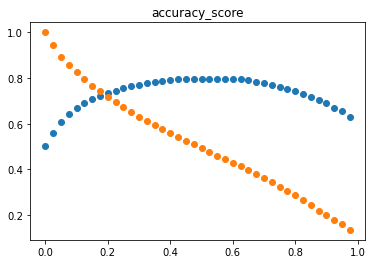

In [11]:
best_score, best_threshold = optimize_accuracy(_oof, list(train_set["state"]))
print(best_score, best_threshold)

In [12]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.title('f1_score')
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.804143622157844 0.375


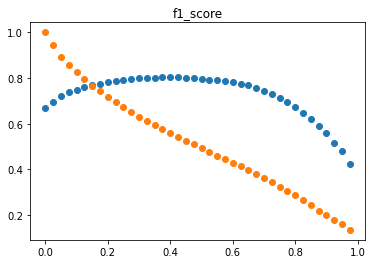

In [13]:
best_score, best_threshold = optimize_threshold(_oof, list(train_set["state"]))
print(best_score, best_threshold)

In [14]:
config_dict = {
    "selected_feature": feature_cols,
    "out_of_fold": list(_oof),
    "prediction": list(_preds),
}

In [15]:
with open("data/base_feature_config_lgmb.json", 'w') as f:
    json.dump(config_dict, f)